# <center>Case Study 4<center>
**<center>CAO Ye<center>**
**<center>QI Zihan<center>**
**<center>SU Xiaochen<center>**

# I. Problem Statement

We’re ready to expand our data science career. Six months from now, we’ll apply for a new job. In preparation, we begin to draft our resume. The early draft is rough and incomplete. It doesn’t yet cover our career goals or education. Nonetheless, the resume covers the first four case studies in this book, including this one, which we’ll complete before seeking new employment.

Our resume draft is far from perfect. It’s possible that certain vital data science skills are not yet represented. If so, what are those missing skills? We decide to find out analytically. After all, we are data scientists! We fill in gaps in knowledge using rigorous analysis, so why shouldn’t we apply that rigorous analysis to ourselves?

First we need some data. We go online and visit a popular job-search site. The website offers millions of searchable job listings, posted by understaffed employers. A built-in search engine allows us to filter the jobs by keyword, such as analyst or data scientist. Additionally, the search engine can match jobs to uploaded documents. This feature is intended to search postings based on resume content. Unfortunately, our resume is still a work in progress. So instead, we search on the table of contents of this book! We copy and paste the first 15 listed sections of the table of contents into a text file.

Next, we upload the file to the job-search site. Material from the first four case studies is compared against millions of job listings, and thousands of job postings are returned. Some of these postings may be more relevant than others; we can’t vouch for the search engine’s overall quality, but the data is appreciated. We download the HTML from every posting.

Our goal is to extract common data science skills from the downloaded data. We’ll then compare these skills to our resume to determine which skills are missing. To reach our goal, we’ll proceed like this:

Parse out all the text from the downloaded HTML files.

Explore the parsed output to learn how job skills are commonly described in online postings. Perhaps specific HTML tags are more commonly used to underscore job skills.

Try to filter out any irrelevant job postings from our dataset. The search engine isn’t perfect. Perhaps some irrelevant postings were erroneously downloaded. We can evaluate relevance by comparing the postings with our resume and the table of contents.

Cluster the job skills within the relevant postings, and visualize the clusters.

Compare the clustered skills to our resume content. We’ll then make plans to update our resume with any missing data science skills.

**The process idea for solving the problem is as follows:**

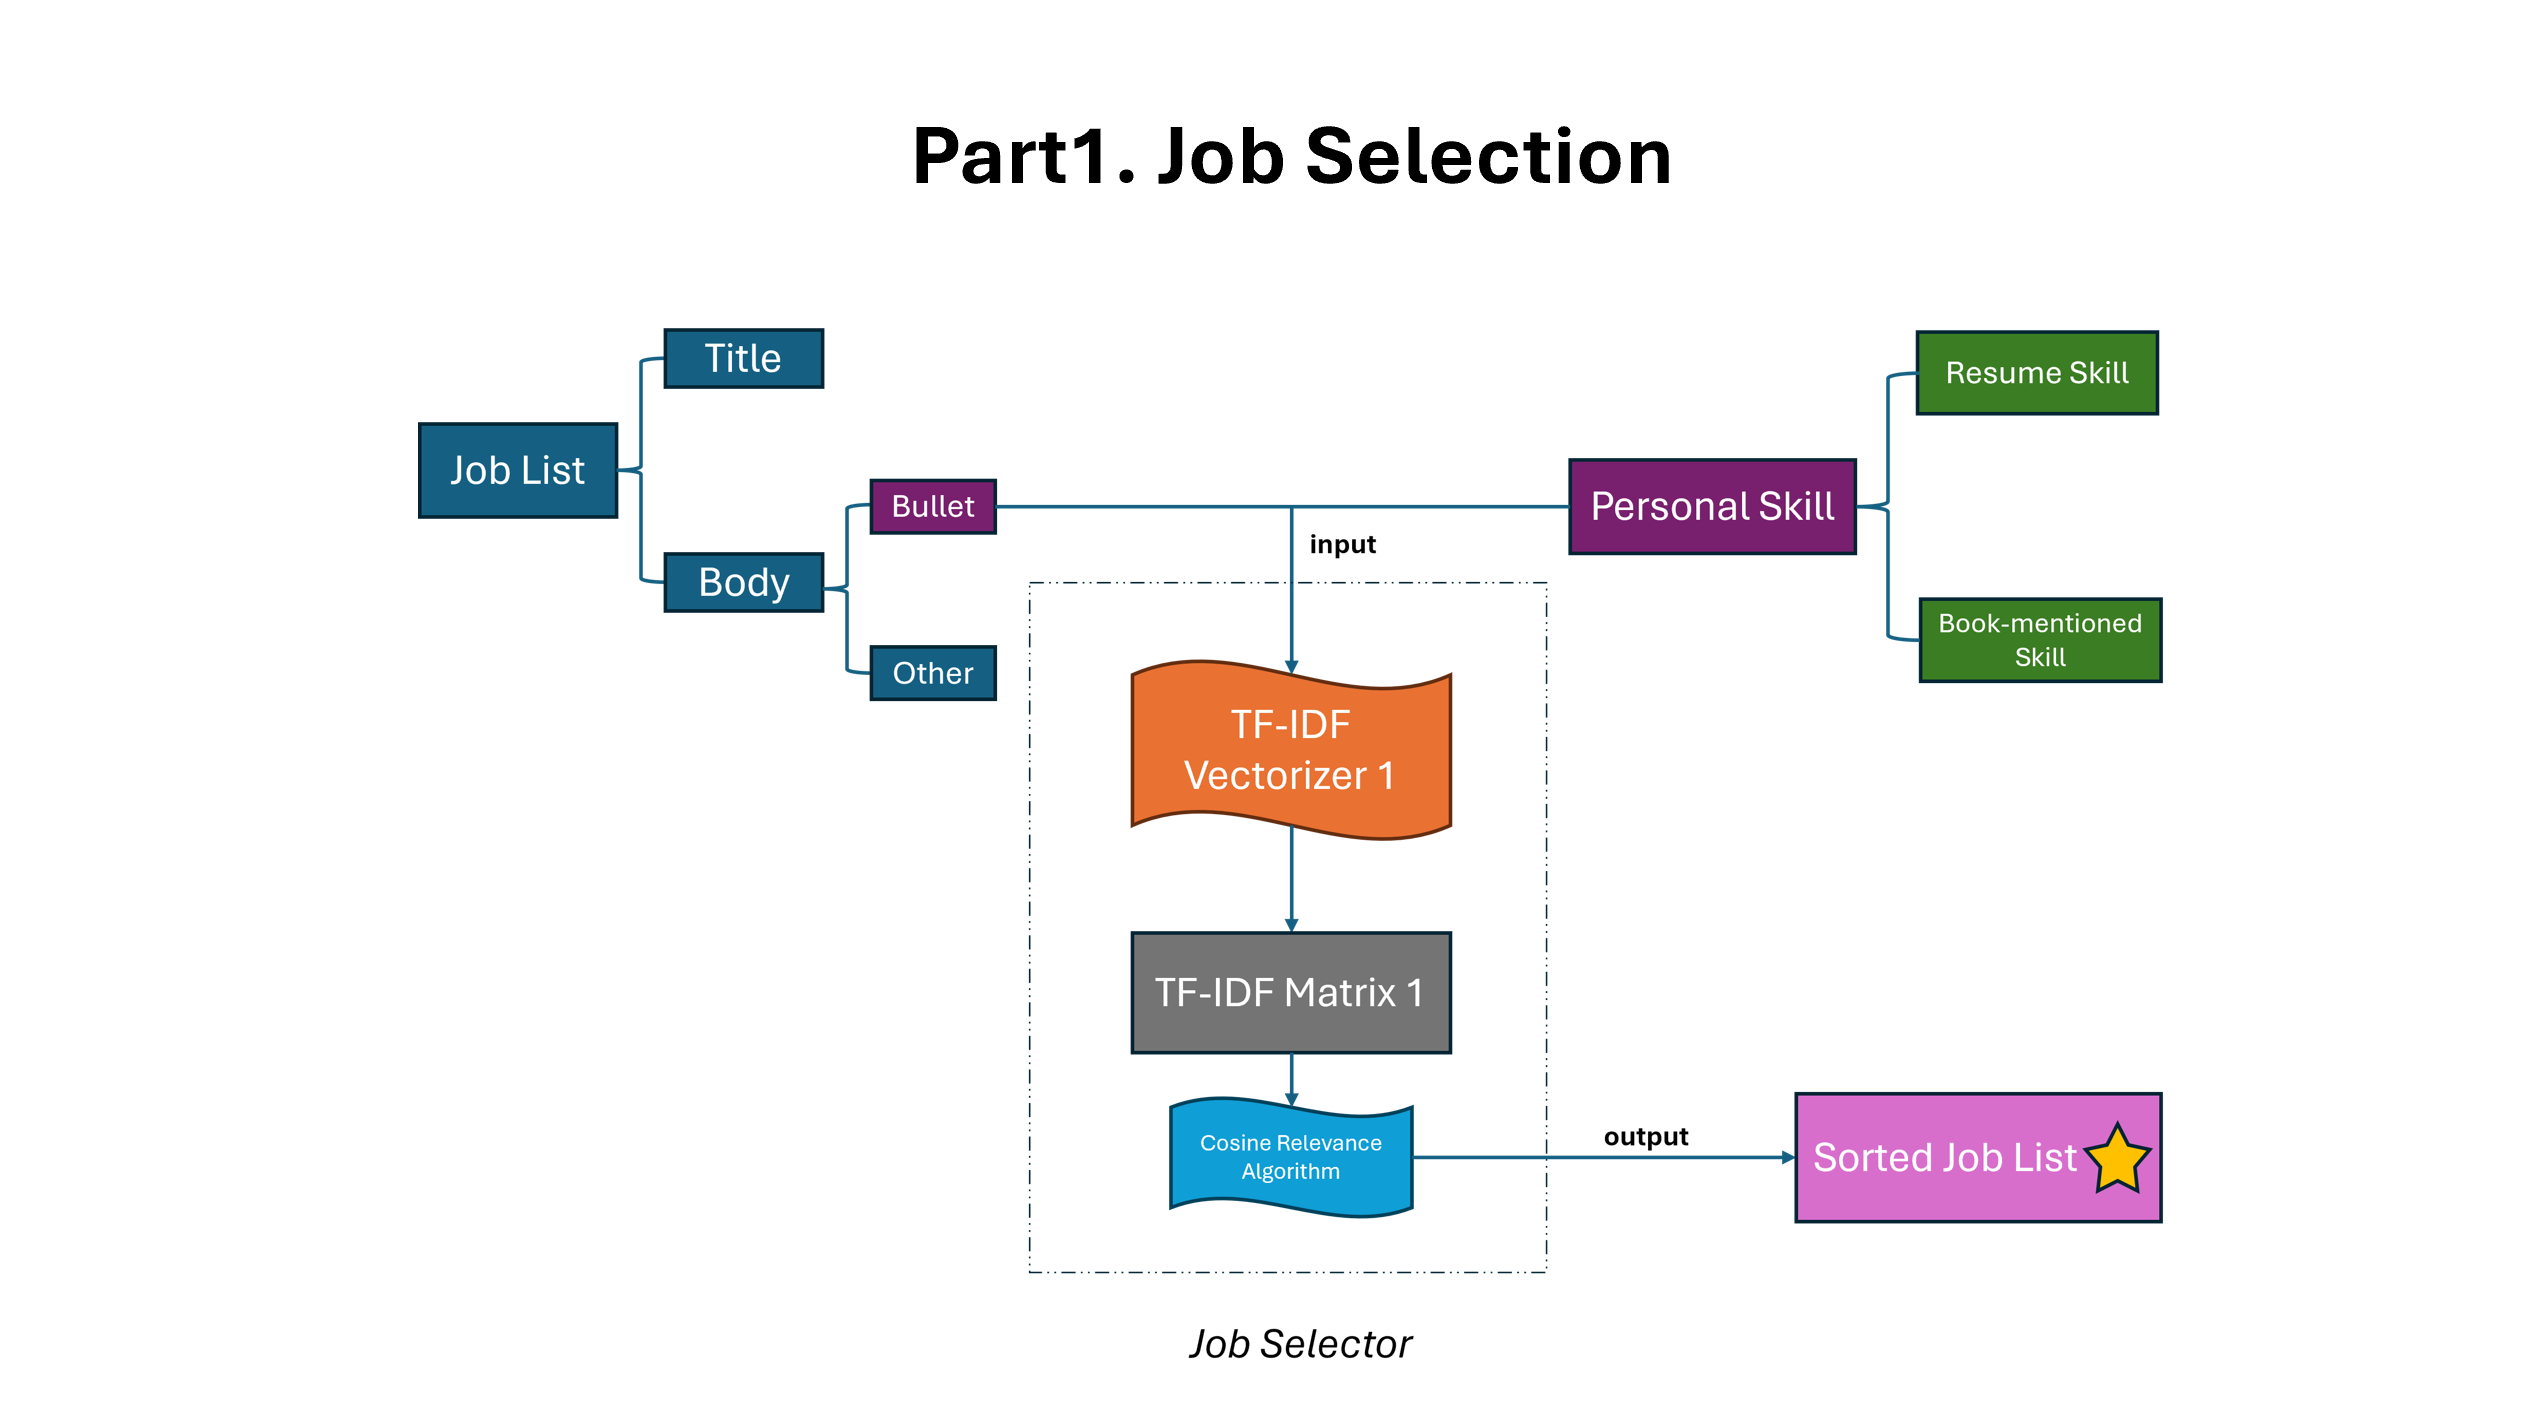

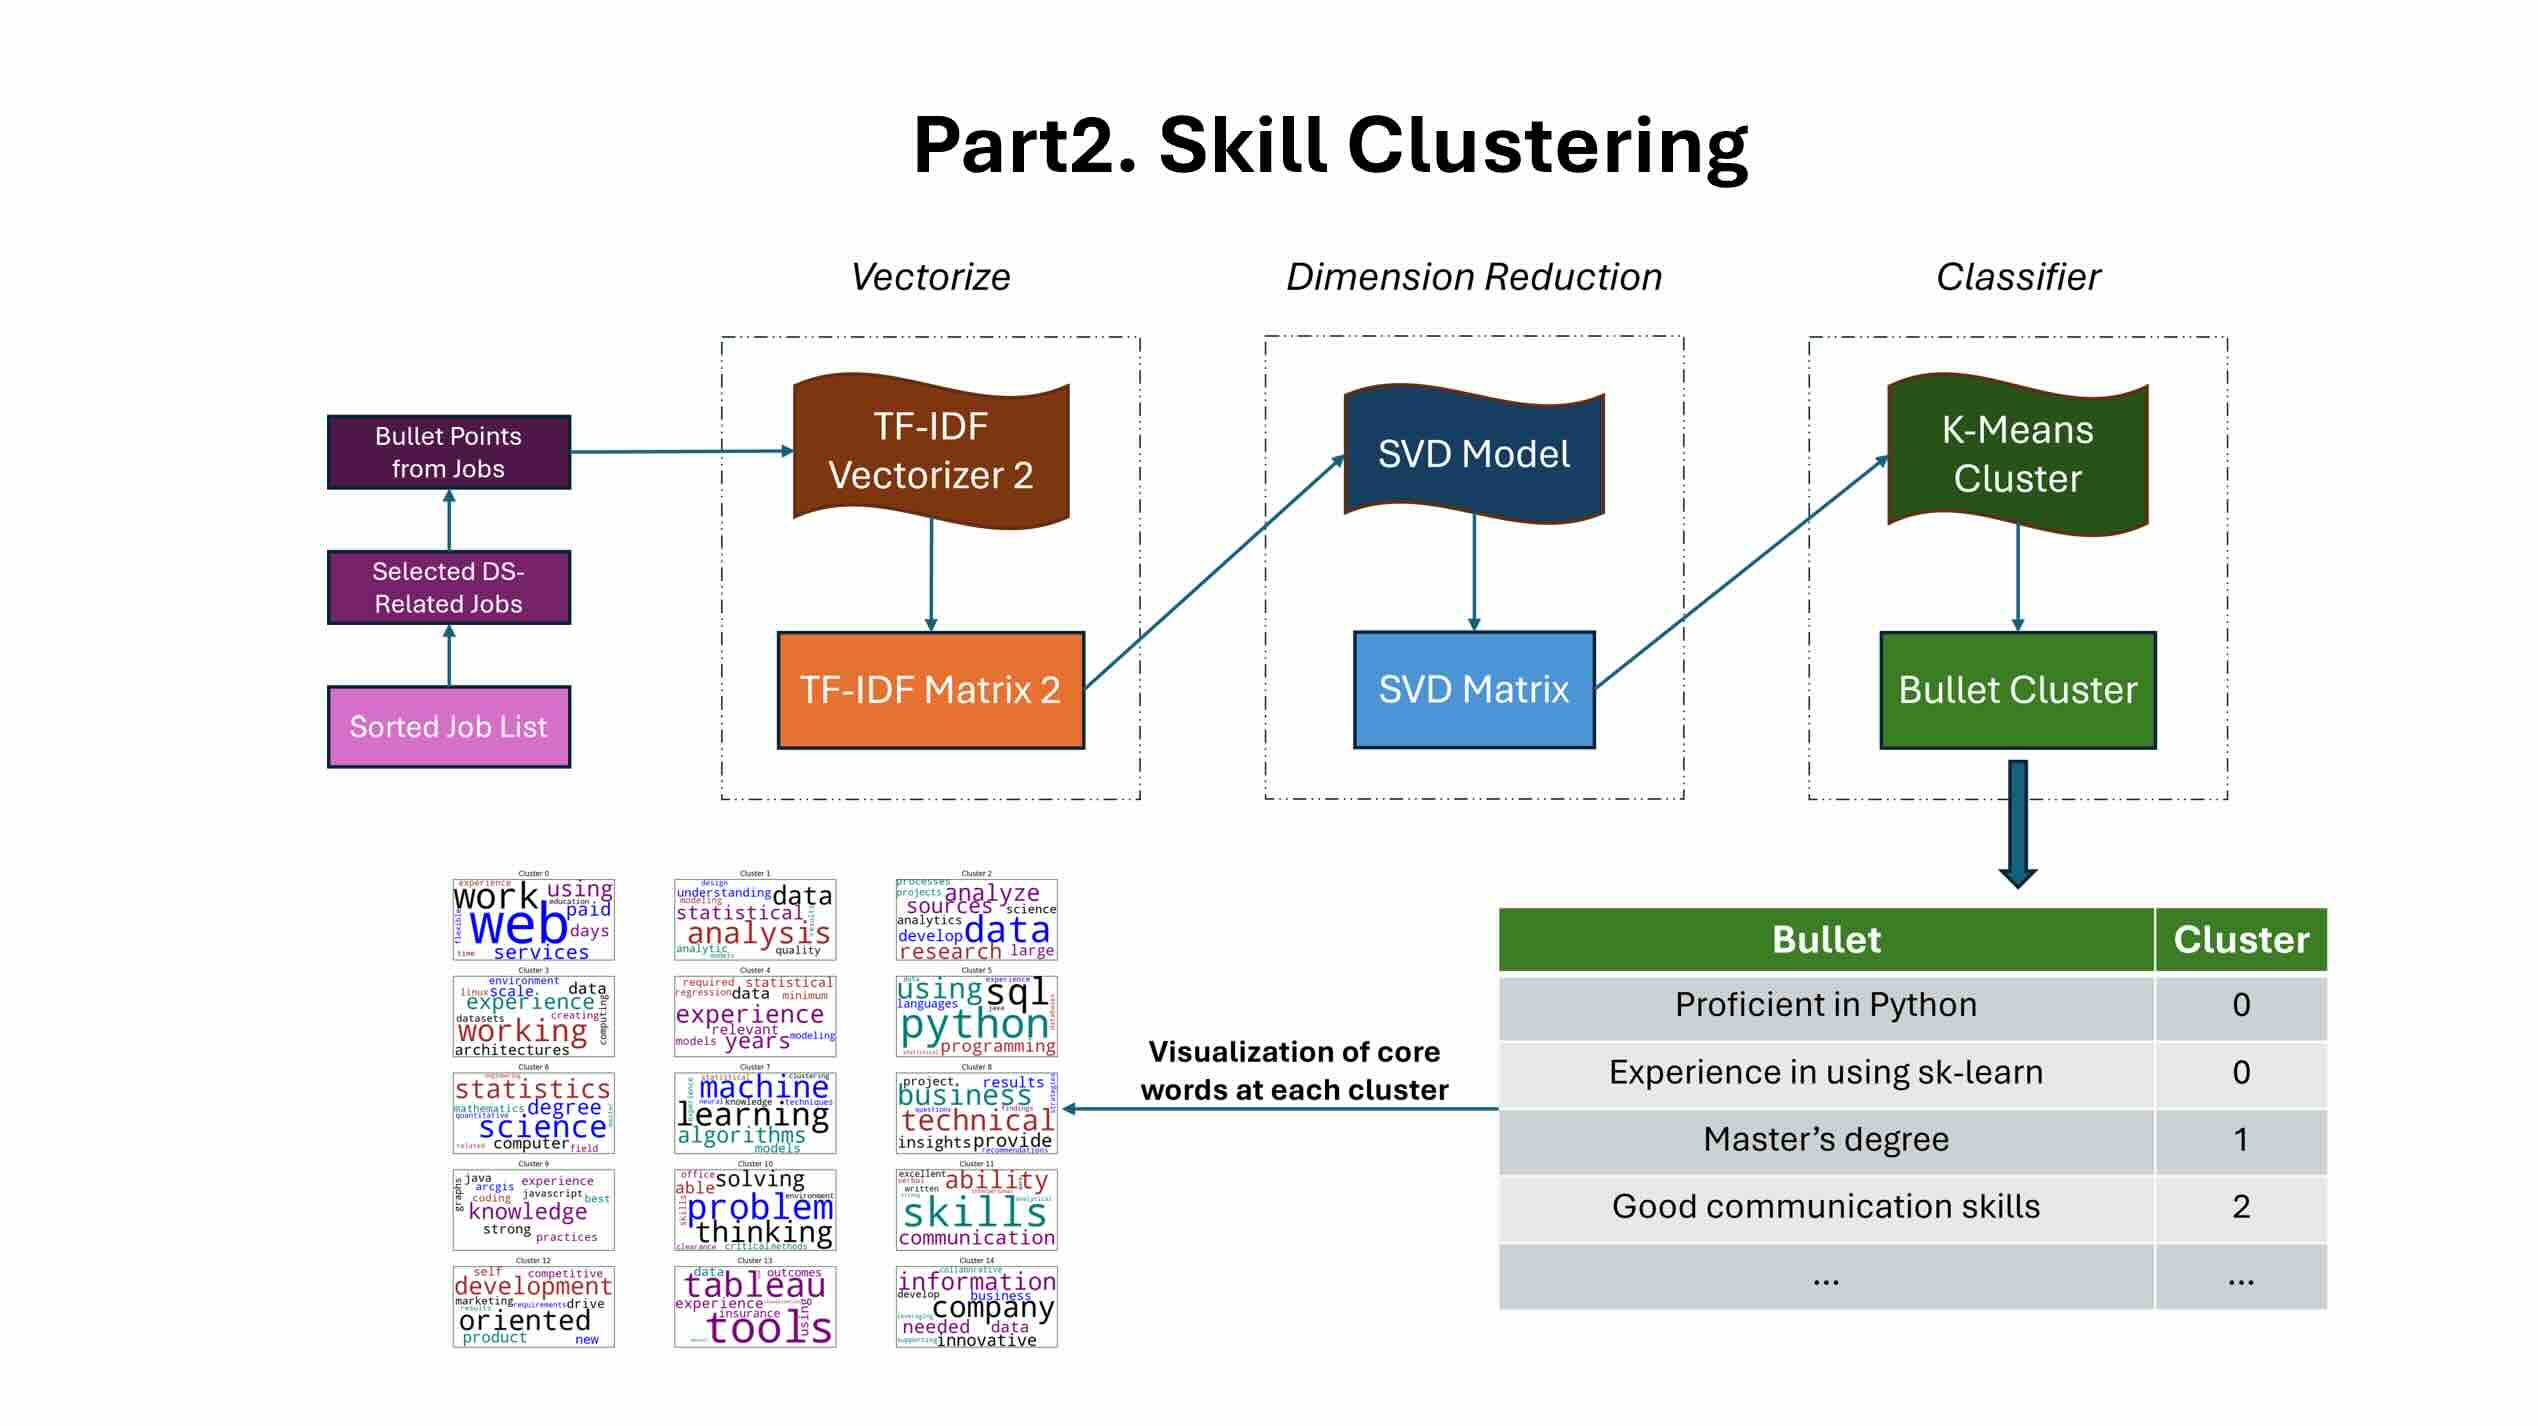

# II. Solution

## 17.2. Extracting Skill Requirements from Job Posting Data

We'll begin by loading all the HTML files in the `job_postings` directory.

**Listing 17. 1. Loading HTML files**

In [ ]:
import glob
html_contents = []  #list of html files

for file_name in sorted(glob.glob('job_postings/*.html')):
    with open(file_name, 'r') as f:
        html_contents.append(f.read())

print(f"We've loaded {len(html_contents)} HTML files.")

We've loaded 1458 HTML files.


We've loaded 1458 HTML files into `html_contents`. Each HTML file can be parsed using Beautiful Soup.

**Listing 17. 2. Parsing HTML files**

In [ ]:
#pip install pandas
#pip install beautifulsoup4

In [ ]:
from bs4 import BeautifulSoup as bs

soup_objects = []
for html in html_contents:
    soup = bs(html)
    assert soup.title is not None
    assert soup.body is not None
    soup_objects.append(soup)

Each parsed HTML file contains a title and a body.  Are there any duplicates across the titles or bodies of these files? We can find out by using Pandas.

**Listing 17. 3. Checking title and body texts for duplicates**

In [ ]:
import pandas as pd
html_dict = {'Title': [], 'Body': []}

for soup in soup_objects:
    title = soup.find('title').text
    body = soup.find('body').text
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)

df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
print(summary)

                                Title  \
count                            1458   
unique                           1364   
top     Data Scientist - New York, NY   
freq                               13   

                                                     Body  
count                                                1458  
unique                                               1458  
top     Natural Language Processing Undergraduate Inte...  
freq                                                    1  


In [ ]:
df_jobs

Title  \
0                      Data Scientist - Beavercreek, OH   
1                    Data Scientist - Seattle, WA 98101   
2                           Data Scientist - Newark, CA   
3     Patient Care Assistant / PCA - Med/Surg (Fayet...   
4                  Data Manager / Analyst - Oakland, CA   
...                                                 ...   
1453         Research Statistician - HEOR - Oakland, CA   
1454                    Data Scientist - Glen Mills, PA   
1455              Data Analyst (Part-Time) - Austin, TX   
1456  Manager - Business Development (Central and Ea...   
1457  Natural Language Processing Undergraduate Inte...   

                                                   Body  
0     Data Scientist - Beavercreek, OH\nData Scienti...  
1     Data Scientist - Seattle, WA 98101\nAre you in...  
2     Data Scientist - Newark, CA\nData Scientist\n\...  
3     Patient Care Assistant / PCA - Med/Surg (Fayet...  
4     Data Manager / Analyst - Oakland, CA\nHOW YOU ...  
...                                                 ...  
1453  Research Statistician - HEOR - Oakland, CA\nPr...  
1454  Data Scientist - Glen Mills, PA\nSSRS Data Sci...  
1455  Data Analyst (Part-Time) - Austin, TX\nABOUT S...  
1456  Manager - Business Development (Central and Ea...  
1457  Natural Language Processing Undergraduate Inte...  

[1458 rows x 2 columns]

We’ve confirmed that no duplicates are present within the html. Now, lets explore the HTML content in more detail. The goal of our exploration will be to determine how job-skills are described in the HTML.

### 17.2.1. Exploring the HTML for Skill Descriptions

We’ll start our exploration by rendering the HTML at index of 0 of `html_contents`.

**Listing 17. 4. Rendering the HTML of the first job-posting**

In [ ]:
from IPython.core.display import display, HTML
assert len(set(html_contents)) == len(html_contents)
display(HTML(html_contents[0]))

C:\Users\SU Xiaochen\AppData\Local\Temp\ipykernel_13716\1415118337.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


We can subdivide `html_contents[0]` into 2 conceptually-different parts:

.. An initial job summary.
.. A list of bulleted skills required to get the job.

Is the next job posting structured in a similar manner? Lets find out, by rendering `html_contents[1]`.

**Listing 17. 5. Rendering the HTML of the second job-posting**

In [ ]:
display(HTML(html_contents[1]))

The bullet-points in `html_contents[0]` and `html_contents[1]` serve a singular purpose. They offer us brief, sentence-length descriptions of unique skills required for each position.

Do these types of bulleted skill descriptions appear in other job posts? We’ll now find out. First, we’ll extract the bullets from each of our parsed html files.

**Listing 17. 6. Extracting bullets from the HTML**

In [ ]:
df_jobs['Bullets'] = [[bullet.text.strip()
                      for bullet in soup.find_all('li')]
                      for soup in soup_objects]

What percentage of job postings actually contain bulleted text? We need to find out! If that percentage is too low, then further bullet-analysis is not worth our time.

**Listing 17. 7. Measuring the percent of bulleted postings**

In [ ]:
bulleted_post_count = 0
for bullet_list in df_jobs.Bullets:
    if bullet_list:
        bulleted_post_count += 1

percent_bulleted = 100 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullets")

90.53% of the postings contain bullets


90% of the job postings contain bullets. Do all (or most) of these bullets focus on skills? We better gage the contents of the bullet-points by printing the top-ranked words within their texts. Below, we'll we rank the words using summed TFDIF values.

**Listing 17. 8. Examining the top-ranked words in the HTML bullet**

In [ ]:
#pip install scikit-learn

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def rank_words(text_list):
    vectorizer = TfidfVectorizer(stop_words='english')                  #stop_words='english'英语中的常用词(the，an...)会被忽略，降低噪声聚焦于更有信息的词
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()        #tfidf_matrix: num of text X num of total words. tfidf衡量着一个词在文本中的重要性
    df = pd.DataFrame({'Words': vectorizer.get_feature_names_out(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

all_bullets = []
for bullet_list in df_jobs.Bullets:
    all_bullets.extend(bullet_list)

sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
experience    878.030398
      data    842.978780
    skills    440.780236
      work    371.684232
   ability    370.969638


Terms such as _skills_ and _ability_ appear among the top 5 bulleted words. How do these bulleted words compare to the remaining words in each job posting? Lets find out.

**Listing 17. 9. Examining the top-ranked words in the HTML bodies**

In [ ]:
non_bullets = []
for soup in soup_objects:
    body = soup.body
    for tag in body.find_all('li'):
        tag.decompose()                 # deleting the parts with tag = <li>

    non_bullets.append(body.text)

sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data     99.111312
      team     39.175041
      work     38.928948
experience     36.820836
  business     36.140488


The words _skills_ and _ability_ are no longer present in the ranked output.  Thus, the non-bulleted text appears to be less skill-oriented than the bullet contents.

Strangely, the words _scientist_ and _science_ is missing from the list. Perhaps some posts pertain to data-driven jobs which aren't directly data science jobs? Lets actively explore this possibility.

**Listing 17. 10. Checking titles for references to data science positions**

In [ ]:
regex = r'Data Scien(ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]

percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f"{percent_non_ds:.2f}% of the job posting titles do not mention a "
       "data science position. Below is a sample of such titles:\n")

for title in df_non_ds_jobs.Title[:10]:
    print(title)

64.33% of the job posting titles do not mention a data science position. Below is a sample of such titles:

Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL
Data Manager / Analyst - Oakland, CA
Scientific Programmer - Berkeley, CA
JD Digits - AI Lab Research Intern - Mountain View, CA
Operations and Technology Summer 2020 Internship-West Coast - Universal City, CA
Data and Reporting Analyst - Olympia, WA 98501
Senior Manager Advanced Analytics - Walmart Media Group - San Bruno, CA
Data Specialist, Product Support Operations - Sunnyvale, CA
Deep Learning Engineer - Westlake, TX
Research Intern, 2020 - San Francisco, CA 94105


C:\Users\SU Xiaochen\AppData\Local\Temp\ipykernel_13716\2465209268.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_non_ds_jobs = df_jobs[~df_jobs.Title.str.contains(regex, case=False)]


In [ ]:
df_non_ds_jobs.shape[0]

938

938 jobs are not mentioning ds

Theirst posting on the list is for a _Patient Care Assistant_ or _PCA_. The erroneous posting contains skills that we both lack and also have no interest in obtaining.

**Listing 17. 11. Sampling bullets from a non-data science job**

In [ ]:
bullets = df_non_ds_jobs.Bullets.iloc[0]    #bullet points of first non-ds job
for i, bullet in enumerate(bullets[:5]):
     print(f"{i}: {bullet.strip()}")

0: Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse
1: Accurately documents care provided
2: Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning
3: Participates in economical utilization of supplies and ensures that equipment and nursing units are maintained in a clean, safe manner
4: Routinely follows and adheres to all policies and procedures


We need to leverage text similarity in order to filter out those jobs that do not align with our resume content.
Lets proceed to filter the jobs by relevance.

## 17.3. Filtering Jobs by Relevance

Our goal is to evaluate job relevance using text similarity. We'll want to compare the text within each posting to our resume and/or book table-of-contents. In preparation, lets now store our resume within a `resume` string.

**Listing 17. 12. Loading the resume**

In [ ]:
resume = open('resume.txt', 'r').read()
print(resume)

Experience

1. Developed probability simulations using NumPy.
2. Assessed online ad-clicks for statistical significance using Permutation testing.
3. Analyzed disease outbreaks using common clustering algorithms.

Additional Skills

1. Data visualization using Matplotlib.
2. Statistical analysis using SciPy.
3. Processing structured tables using Pandas.
4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.
5. Extracting locations from text using GeonamesCache.
6. Location analysis and visualization using GeonamesCache and Basemap.
7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
8. NLP analysis and text topic detection using Scikit-Learn.


In this same manner, we can store the table of contents within a `table_of_contents` string.

**Listing 17. 13. Loading the table-of-content**

In [ ]:
table_of_contents = open('table_of_contents.txt', 'r').read()
print(table_of_contents)

Case Study 1: Finding the Winning Strategy in a Card Game.

Section 1: Computing Probabilities Using Python
1.1 Sample Space Analysis: An Equation-Free Approach for Measuring Uncertainty in Outcomes.
1.2 Computing Non-Trivial Probabilities
1.3 Computing Probabilities over Interval Ranges

Section 2: Plotting Probabilities Using Matplotlib
2.1. Basic Matplotlib plots
2.2. Plotting Coin-flip Probabilities.


Section 3: Executing Randomized Numerical Simulations Using Python
3.1. Simulating Random Observations Using NumPy
3.2. Computing Confidence Intervals Using Histograms and NumPy Arrays
3.3. Using Confidence Intervals to Analyze a Biased Deck of Cards
3.4. Using Permutations to Shuffle Cards

Section 4: Case Study 1 Solution
4.1. Overview
4.2. Predicting Red Cards within a Shuffled Deck
4.3. Estimating the Probability of Strategy Success
4.4 Key Takeaways

Case Study 2: Assessing Online Ad-Clicks for Significance

Section 5: Basic Probability and Statistical Analysis Using SciPy
5.1. 

Together, `resume` and `table_of_contents` summarize our existing skill-set. Lets concatenate these skills into a single `existing_skills` string.

**Listing 17. 14. Combining skills into a single string**

In [ ]:
existing_skills = resume + table_of_contents

We want to compute all similarities between `df_jobs.Body` and `existing_skills.` This computation first requires that we vectorize all texts.

**Listing 17. 15. Vectorizing our skills and the job-posting data**

In [ ]:
text_list = df_jobs.Body.values.tolist() + [existing_skills]    #tolist(): transforming NumPy array as Python list
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()

Our vectorized texts are stored in a matrix format within `tfidf_matrix`. The final matrix row (`tfidf_matrix[-1]`) corresponds to our existing skill-set. Thus, we can easily compute the cosine similarities between the job postings and `existing_skills`, by running `tfdf_matrix[:-1] @ tfidf_matrix[-1]`.

**Listing 17. 16. Computing skill-based cosine similarities**

In [ ]:
cosine_similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]
# every row except last row(job part) @ last row(skill part) ------------------> one dimentional array
    # interpretation of element i in this array: cos similarity of job i and our skill (since each row is standardized, no need to devide the norm of 2 vectors)

We can leverage `cosine_similarities` to rank to the jobs by relevance. Lets proceed to carry out the ranking. Afterwards, we'll confirm if the 20 least-relevant jobs have anything to do with data science.

**Listing 17. 17. Printing the 20 least-relevant jobs**

In [ ]:
df_jobs['Relevance'] = cosine_similarities
sorted_df_jobs = df_jobs.sort_values('Relevance', ascending=False)
for title in sorted_df_jobs[-20:].Title:
    print(title)

Data Analyst Internship (8 month minimum) - San Francisco, CA
Leadership and Advocacy Coordinator - Oakland, CA 94607
Finance Consultant - Audi Palo Alto - Palo Alto, CA
RN - Hattiesburg, MS
Configuration Management Specialist - Dahlgren, VA
Deal Desk Analyst - Mountain View, CA
Dev Ops Engineer AWS - Rockville, MD
Web Development Teaching Assistant - UC Berkeley (Berkeley) - Berkeley, CA
Scorekeeper - Oakland, CA 94612
Direct Care - All Experience Levels (CNA, HHA, PCA Welcome) - Norwell, MA 02061
Director of Marketing - Cambridge, MA
Certified Strength and Conditioning Specialist - United States
PCA - PCU Full Time - Festus, MO 63028
Performance Improvement Consultant - Los Angeles, CA
Patient Services Rep II - Oakland, CA
Lab Researcher I - Richmond, CA
Part-time instructor of Statistics for Data Science and Machine Learning - San Francisco, CA 94105
Plant Engineering Specialist - San Pablo, CA
Page Not Found - Indeed Mobile
Director of Econometric Modeling - External Careers


Almost all the printed jobs are completely irrelevant! Now, for comparison’s sake, lets print the 20 most-relevant job titles in `sorted_ds_jobs`.

**Listing 17. 18. Printing the 20 most-relevant jobs**

In [ ]:
for title in sorted_df_jobs[:20].Title:
    print(title)

Chief Data Officer - Culver City, CA 90230
Data Scientist - Beavercreek, OH
Data Scientist Population Health - Los Angeles, CA 90059
Data Scientist - San Diego, CA
Data Scientist - Beavercreek, OH
Senior Data Scientist - New York, NY 10018
Data Architect - Raleigh, NC 27609
Data Scientist (PhD) - Spring, TX
Data Science Analyst - Chicago, IL 60612
Associate Data Scientist (BS / MS) - Spring, TX
Data Scientist - Streetsboro, OH 44241
Data Scientist - Los Angeles, CA
Sr Director of Data Science - Elkridge, MD
2019-57 Sr. Data Scientist - Reston, VA 20191
Data Scientist (PhD) - Intern - Spring, TX
Sr Data Scientist. - Alpharetta, GA 30004
Data Scientist GS 13/14 - Clarksburg, WV 26301
Data Science Intern (BS / MS) - Intern - Spring, TX
Senior Data Scientist - New York, NY 10038
Data Scientist - United States


Whenv`df_jobs.Relevance` is high, the associated job postings are relevant. As `df_jobs.Relevance` decreases, the associated jobs become less relevant. Thus, we can presume that there exists some `df_jobs.Relevance` cutoff, which separates the relevant jobs from the non-relevant jobs. Lets try to identify that cutoff. by visualizing the shape of the sorted relevance distribution.

**Listing 17. 19. Plotting job-ranking vs relevance**

In [ ]:
#pip install matplotlib

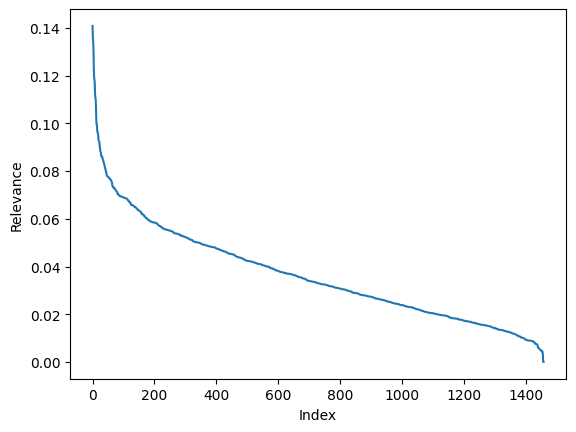

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

Our relevance curve resembles a K-means Elbow plot. Initially, the relevance drops rapidly. Then, at an x-value of approximately 60, the curve begins to level off. Lets emphasize this transition by striking a vertical line through the x-position of 60 in our plot.

**Listing 17. 20. Adding a cutoff to the relevance plot**

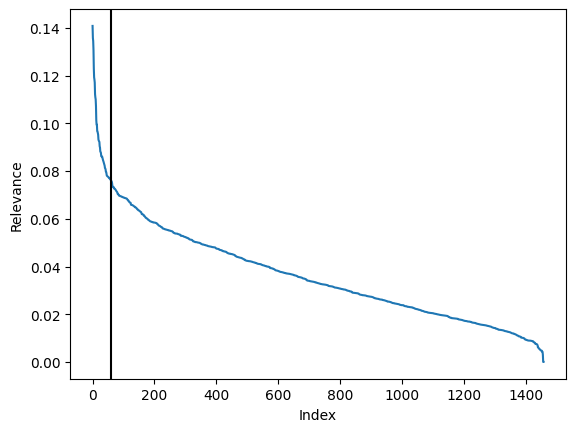

In [ ]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs.Relevance.values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

Our plot implies that the first 60 jobs are noticeably more relevant than all subsequent jobs. Based on our hypothesis, jobs 40 - 60 should be highly relevant.

**Listing 17. 21. Printing jobs below the relevance cutoff**

In [ ]:
for title in sorted_df_jobs[40: 60].Title.values:
    print(title)

Data Scientist III - Pasadena, CA 91101
Global Data Engineer - Boston, MA
Data Analyst and Data Scientist - Summit, NJ
Data Scientist - Generalist - Glendale, CA
Data Scientist - Seattle, WA
IT Data Scientist - Contract - Riverton, UT
Data Scientist (Analytic Consultant 4) - San Francisco, CA
Data Scientist - Seattle, WA
Data Science & Tagging Analyst - Bethesda, MD 20814
Data Scientist - New York, NY
Senior Data Scientist - Los Angeles, CA
Principal Statistician - Los Angeles, CA
Senior Data Analyst - Los Angeles, CA
Data Scientist - Aliso Viejo, CA 92656
Data Engineer - Seattle, WA
Data Scientist - Digital Factory - Tampa, FL 33607
Data Scientist - Grapevine, TX 76051
Data Scientist - Bioinformatics - Denver, CO 80221
EPIDEMIOLOGIST - Los Angeles, CA
Data Scientist - Bellevue, WA


Almost all the printed jobs are are highly relevant. Implicity, the relevance should decrease when we print the next 20 job-titles, since they lie beyond the bounds of index 60. Lets verify if this is the case.

**Listing 17. 22. Printing jobs beyond the relevance cutoff**

In [ ]:
for title in sorted_df_jobs[60: 80].Title.values:
    print(title)

Data Scientist - Aliso Viejo, CA
Data Scientist and Visualization Specialist - Santa Clara Valley, CA 95014
Data Scientist - Los Angeles, CA
Data Scientist Manager - NEW YORK LOCATION! - New York, NY 10036
Data Science Intern - San Francisco, CA 94105
Research Data Analyst - San Francisco, CA
Sr Data Scientist (Analytic Consultant 5) - San Francisco, CA
Data Scientist, Media Manipulation - Cambridge, MA
Manager, Data Science, Programming and Visualization - Boston, MA
Data Scientist in Broomfield, CO - Broomfield, CO
Senior Data Scientist - Executive Projects and New Solutions - Foster City, CA
Manager of Data Science - Burbank California - Burbank, CA
Data Scientist Manager - Hiring in Burbank! - Burbank, CA
Data Scientists needed in NY - Senior Consultants and Managers! - New York, NY 10036
Data Scientist - Menlo Park, CA
Data Engineer - Santa Clara, CA
Data Scientist - Remote
Data Scientist I-III - Phoenix, AZ 85021
SWE Data Scientist - Santa Clara Valley, CA 95014
Health Science Sp

A majority of the printed jobs refer to data science / analyst roles, outside the scope of health science or management. We can quickly quantify this observation using regular expressions. Below, we’ll define a `percent_relevant_tiles` function, which returns the percent of non-management data science and analysis jobs within a data frame slice.

**Listing 17. 23. Measuring title relevance in a subset of jobs**

In [ ]:
import re
def percent_relevant_titles(df):
    regex_relevant = re.compile(r'Data (Scien|Analy)',
                                flags=re.IGNORECASE)
    regex_irrelevant = re.compile(r'\b(Manage)',
                                  flags=re.IGNORECASE)
    match_count = len([title for title in df.Title
                       if regex_relevant.search(title)
                       and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

percent = percent_relevant_titles(sorted_df_jobs[60: 80])
print(f"Approximately {percent:.2f}% of job titles between indices "
       "60 - 80 are relevant")

Approximately 65.00% of job titles between indices 60 - 80 are relevant


Approximately 65% of the job-titles in `sorted_df_jobs[60: 80]` are relevant. Perhaps that percentage will drop if we sample the next 20 jobs, across an index range of 80 - 100.

**Listing 17. 24. Measuring title relevance in the next subset of jobs**

In [ ]:
percent = percent_relevant_titles(sorted_df_jobs[80: 100])
print(f"Approximately {percent:.2f}% of job titles between indices "
       "80 - 100 are relevant")

Approximately 80.00% of job titles between indices 80 - 100 are relevant


Nope! The data science title-percentage rose to 80%. At what point will the percentage drop below 50%? We can easily find out, using a plot.

**Listing 17. 25. Plotting percent relevance across all title samples**

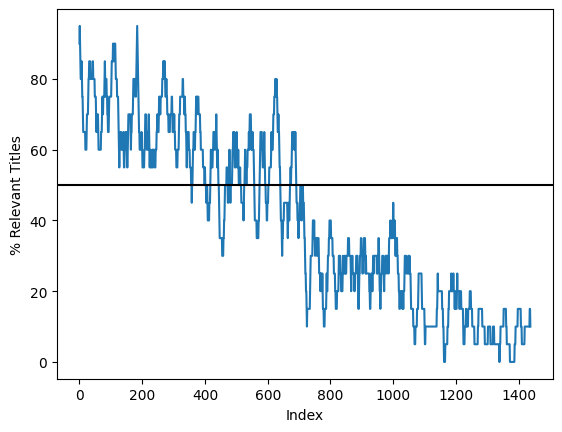

In [ ]:
def relevant_title_plot(index_range=20):
    percentages = []
    start_indices = range(df_jobs.shape[0] - index_range)
    for i in start_indices:
        df_slice = sorted_df_jobs[i: i + index_range]
        percent = percent_relevant_titles(df_slice)
        percentages.append(percent)

    plt.plot(start_indices, percentages)
    plt.axhline(50, c='k')
    plt.xlabel('Index')
    plt.ylabel('% Relevant Titles')

relevant_title_plot()
plt.show()

The relevant Data Science titles drop below 50% at an index of around 700. Of course, its possible that the cutoff of 700 is merely an artifact of our chosen index range. Will the cutoff still be present if double our index range? Lets find out.

**Listing 17. 26. Plotting percent relevance across an increased index-range**

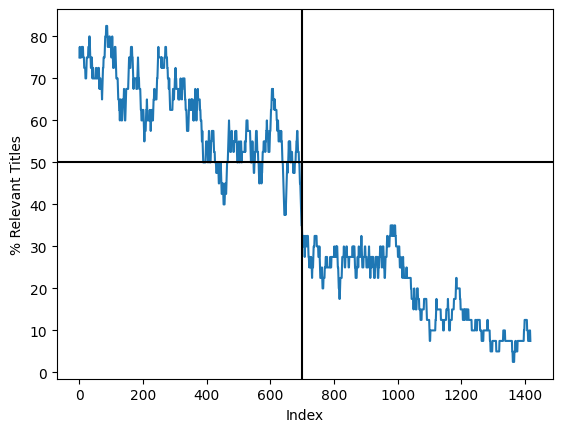

In [ ]:
relevant_title_plot(index_range=40)
plt.axvline(700, c='k')
plt.show()

Our updated plot continues to drop below 50% at an index cutoff of 700.


At this point, we face a choice between 2 relevance cutoffs. Our first cutoff, at index 60, is highly precise. Meanwhile, our second cutoff of 700 captures many-more data science positions. So, which cutoff do we choose?  How about we try both cutoffs? That way compare the tradeoffs and benefits of each!

We will now proceed to cluster the skills within the relevant job postings. Initially, we’ll set our relevance cutoff to an index of 60.

## 17.4. Clustering Skills in Relevant Job Postings

Our aim is to cluster the skills within the 60 most-relevant job postings. The skills within each posting are diverse, and partially represented by bullet-points. Consequently, we’ll proceed to cluster the scraped bullets. We’ll start by storing `sorted_df_jobs[:60].Bullets` within a single list.

**Listing 17. 27. Obtaining bullets from the 60 most-relevant jobs**

In [ ]:
total_bullets = []
for bullets in sorted_df_jobs[:60].Bullets:
    total_bullets.extend(bullets)

How many bullets are present in the list? Also, are any of the bullets duplicated? We can check using Pandas.

**Listing 17. 28. Summarizing basic bullet statistic**

In [ ]:
df_bullets = pd.DataFrame({'Bullet': total_bullets})
print(df_bullets.describe())

                                                   Bullet
count                                                1091
unique                                                900
top     Knowledge of advanced statistical techniques a...
freq                                                    9


Only 900 of the bullets are unique. Below, we’ll filter empty strings and duplicates from our bullet list. Afterwards, we’ll vectorize the list using a TFIDF vectorizer.

**Listing 17. 29. Removing duplicates and vectorizing the bullets**

In [ ]:
total_bullets = sorted(set(total_bullets))              #set() automaticaly eliminates duplication
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(total_bullets)
num_rows, num_columns = tfidf_matrix.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")

Our matrix has 900 rows and 2070 columns


Our vectorized TFIDF matrix is too large for efficient clustering. Lets dimensionally reduce the matrix using the procedure described in Section Fifteen.

**Listing 17. 30. Dimensionally reducing the TFIDF matrix**

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
np.random.seed(0)

def shrink_matrix(tfidf_matrix):
    svd_object = TruncatedSVD(n_components=100)
    shrunk_matrix = svd_object.fit_transform(tfidf_matrix)
    return normalize(shrunk_matrix)

shrunk_norm_matrix = shrink_matrix(tfidf_matrix)

We are nearly ready to cluster our normalized matrix using K-means. However, we’ll first need to estimate K using an Elbow plot.

**Listing 17. 31. Plotting an elbow curve using Mini Batch K-Means**

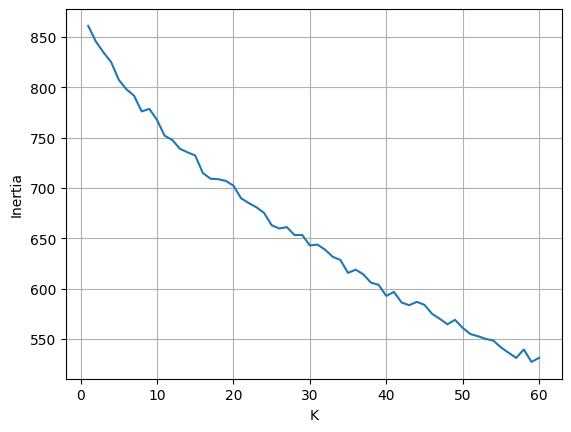

In [ ]:
np.random.seed(0)
from sklearn.cluster import MiniBatchKMeans
def generate_elbow_plot(matrix):
    k_values = range(1, 61)
    inertia_values = [MiniBatchKMeans(k).fit(matrix).inertia_
                      for k in k_values]
    plt.plot(k_values, inertia_values)
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

generate_elbow_plot(shrunk_norm_matrix)

The precise location of a bent elbow-shaped transition is difficult to spot. We don't know which K-value to choose. Lets cluster our data multiple times, using K-values of 10, 15, 20, and 25. Afterwards, we’ll compare and contrast the results.

### 17.4.1. Grouping the Job Skills into 15 Clusters

Below, we’ll execute K-means using a K of 15.

**Listing 17. 32. Clustering bullets into 15 clusters**

In [ ]:
np.random.seed(0)
from sklearn.cluster import KMeans

def compute_cluster_groups(shrunk_norm_matrix, k=15):
    cluster_model = KMeans(n_clusters=k)
    clusters = cluster_model.fit_predict(shrunk_norm_matrix)
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': total_bullets})
    return [df_cluster for  _, df_cluster in df.groupby('Cluster')]

cluster_groups = compute_cluster_groups(shrunk_norm_matrix)

In [ ]:
cluster_groups[1]

Index  Cluster                                             Bullet
127    127        1  Capable of understanding advanced mathematical...
131    131        1  Clearly communicate foundational level underst...
157    157        1  Conceptualize and perform analytic study using...
164    164        1  Constructed data visualization to assist other...
167    167        1  Contribute to all stages of data science or de...
..     ...      ...                                                ...
864    864        1  Work on advanced analytics areas like deep lea...
867    867        1  Work with large, complex data sets. Solve diff...
869    869        1  Work with our quantitative and development tea...
873    873        1  Work with product managers and data engineers ...
897    897        1  Your statistical analysis skills are solid and...

[69 rows x 3 columns]

Each of our text clusters is stored as a Pandas table within the `cluster_groups` list. We can visualize the clusters using word clouds. Below, we will define a `cluster_to_image` function, and then apply it to `cluster_groups[0]`.

**Listing 17. 33. Visualizing the first cluster**

In [ ]:
# pip install wordcloud

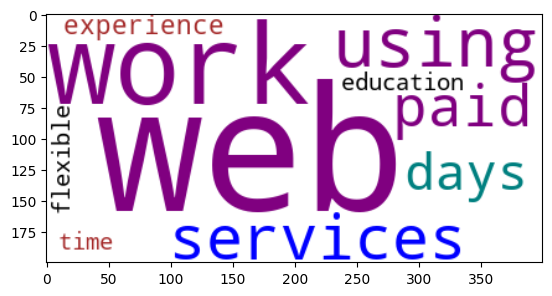

In [ ]:
from wordcloud import WordCloud
np.random.seed(0)

def cluster_to_image(df_cluster, max_words=10, tfidf_matrix=tfidf_matrix,
                     vectorizer=vectorizer):
    indices = df_cluster.Index.values                                           #relevant bullet indices of current cluster
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': vectorizer.get_feature_names_out(),'Summed TFIDF': summed_tfidf}
    df_ranked_words = pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)
    words_to_score = {word: score
                     for word, score in df_ranked_words[:max_words].values    # first 'max_words' rows
                     if score != 0}
    cloud_generator = WordCloud(background_color='white',
                                color_func=_color_func,
                                random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return wordcloud_image

def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

wordcloud_image = cluster_to_image(cluster_groups[0])
plt.imshow(wordcloud_image, interpolation="bilinear")
plt.show()

The language in the word-cloud appears to be describing a focused, data-oriented personality. However, that language is a little vague. Perhaps we can learn more about the cluster by printing some sample bullets from `cluster_group[0]`.

**Listing 17. 34. Printing sample bullets from Cluster 0**

In [ ]:
np.random.seed(1)
def print_cluster_sample(cluster_id):
    df_cluster = cluster_groups[cluster_id]
    for bullet in np.random.choice(df_cluster.Bullet.values, 5,
                                   replace=False):
        print(bullet)

print_cluster_sample(0)

Additional 10 paid holidays annually
Actively participates and contributes in brain-storming session. Can work seamlessly with people from other disciplines: IT engineers, client SMEs, business consultants
Paid time off
Work with data engineers to plan, implement, and automate integration of external data sources across a variety of architectures, including local databases, web APIs, CRM systems, etc
Implemented responsive web pages using HTML5/CSS3 and BOOTSTRAP


Now, lets visualize all 15 clusters using word clouds.

**Listing 17. 35. Visualizing all 15 clusters**

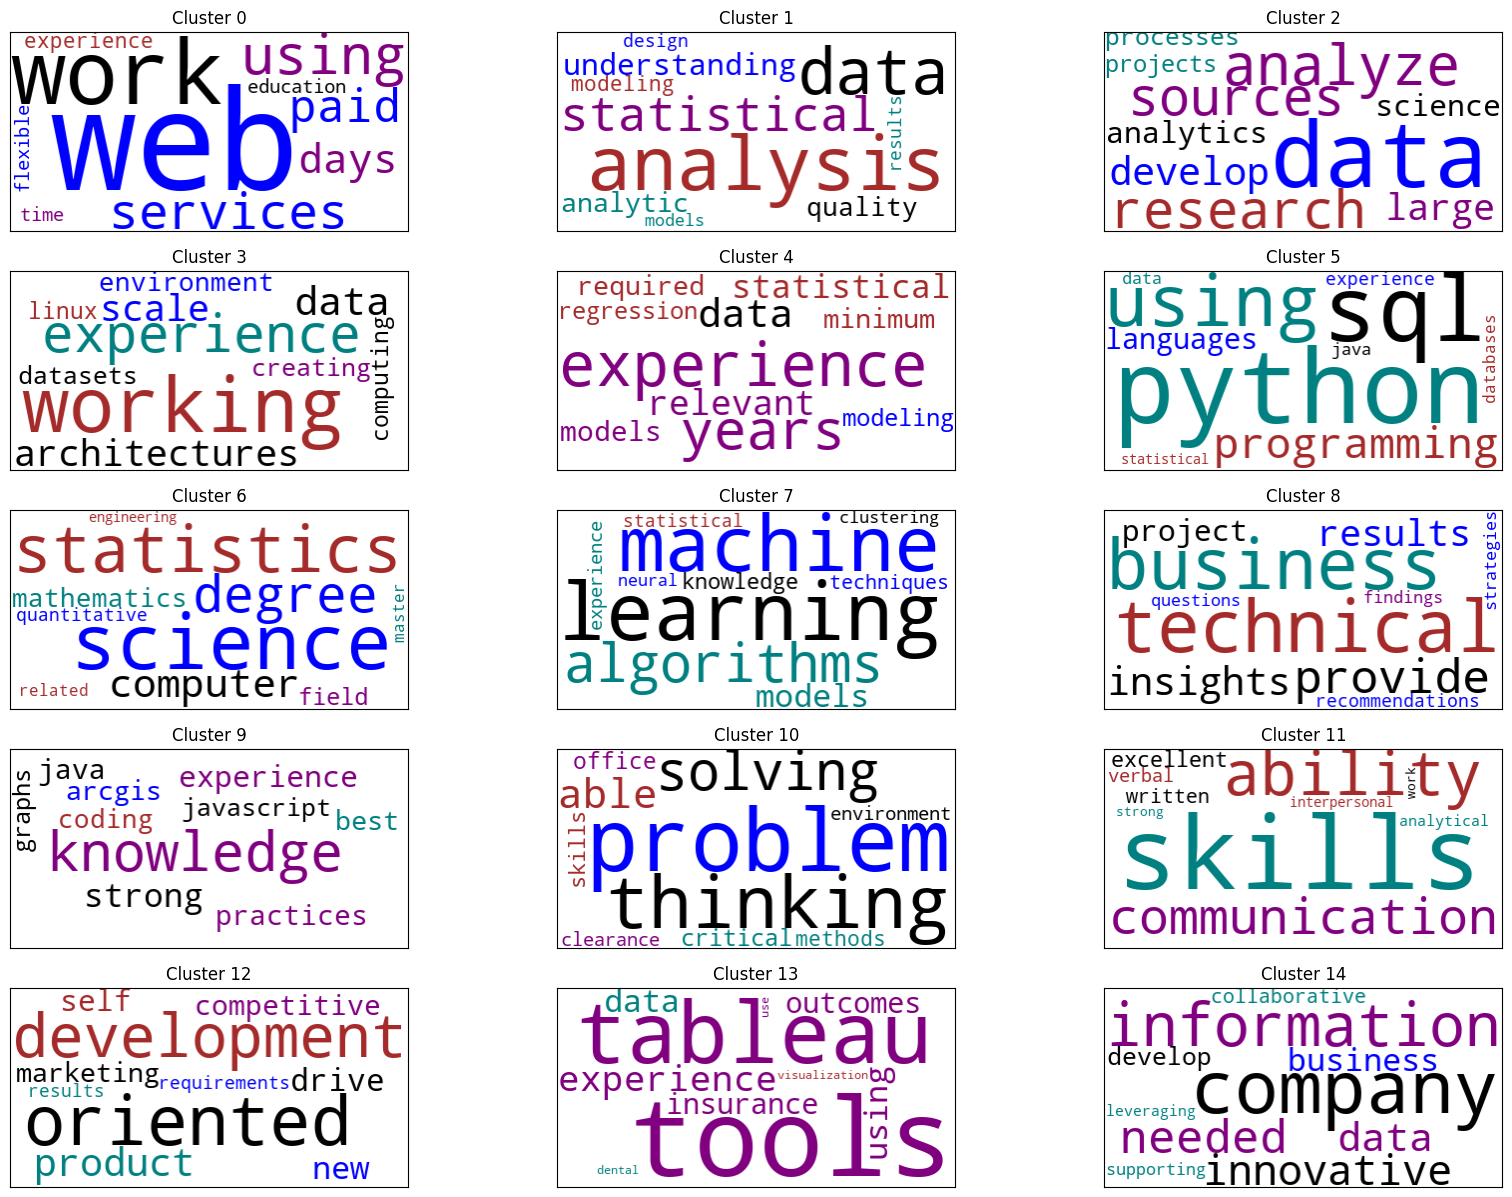

In [ ]:
def plot_wordcloud_grid(cluster_groups, num_rows=5, num_columns=3,
                        **kwargs):
    figure, axes = plt.subplots(num_rows, num_columns, figsize=(20, 15))
    cluster_groups_copy = cluster_groups[:]
    for r in range(num_rows):
        for c in range(num_columns):
            if not cluster_groups_copy:
                break

            df_cluster = cluster_groups_copy.pop(0)
            wordcloud_image = cluster_to_image(df_cluster, **kwargs)
            ax = axes[r][c]
            ax.imshow(wordcloud_image,
            interpolation="bilinear")
            ax.set_title(f"Cluster {df_cluster.Cluster.iloc[0]}")
            ax.set_xticks([])
            ax.set_yticks([])

plot_wordcloud_grid(cluster_groups)
plt.show()

Some of the clusters are highly technical. For instance, Cluster 7 fixates on external data science libraries such as Scikit-Learn, Pandas, NumPy, Matplotlib and SciPy. Lets print sample some bullets from Cluster 7, and confirm their focus on DS libraries.

**Listing 17. 36. Printing sample bullets from Cluster 7**

In [ ]:
np.random.seed(1)
print_cluster_sample(7)

Machine Learning experience using Tensorflow, Scikit-learn, or Spark ML
Understanding of machine learning algorithms, such as k-NN, GBM, Neural Networks Naive Bayes, SVM, and Decision Forests
Minimum 2 years experience working in a data science or machine learning environment.
3 + years of experience using quantitative machine learning techniques
Expert knowledge of machine learning libraries such as scikit-learn, TensorFlow, and keras


Meanwhile, other clusters focus on non-technical skills. Perhaps we can separate the technical clusters and soft-skill clusters using text similarity (to our resume). Lets examine this possibility. We’ll start by computing the cosine similarity between each bullet in `total_bullets` and our resume.

**Listing 17. 37. Computing similarities between the bullets and our resume**

In [ ]:
def compute_bullet_similarity(bullet_texts):
    bullet_vectorizer = TfidfVectorizer(stop_words='english')
    matrix = bullet_vectorizer.fit_transform(bullet_texts + [resume])
    matrix = matrix.toarray()
    return matrix[:-1] @ matrix[-1]

bullet_cosine_similarities = compute_bullet_similarity(total_bullets)

Our `bullet_cosine_similarities` array contains the text similarities across all clustered bullets. For any given cluster, we can combine these cosine similarities into a single similarity score. According to our hypothesis, a technical cluster should have a higher mean similarity than a soft-skill similarity cluster. Lets confirm if this is the case for the technical Cluster 7 and the soft-skill Cluster 0.

**Listing 17. 38. Comparing mean resume similarities**

In [ ]:
def compute_mean_similarity(df_cluster):
    indices = df_cluster.Index.values
    return bullet_cosine_similarities[indices].mean()

tech_mean = compute_mean_similarity(cluster_groups[7])
soft_mean =  compute_mean_similarity(cluster_groups[0])
print(f"Technical cluster 7 has a mean similarity of {tech_mean:.3f}")
print(f"Soft-skill cluster 3 has a mean similarity of {soft_mean:.3f}")

Technical cluster 7 has a mean similarity of 0.073
Soft-skill cluster 3 has a mean similarity of 0.045


The technical cluster is 10x more proximate to our resume than the soft-skill cluster. Lets compute the average similarity for all 15 clusters. Afterwards, we’ll sort the clusters by their similarity score, in descending order.

**Listing 17. 39. Sorting subplots by resume similarity**

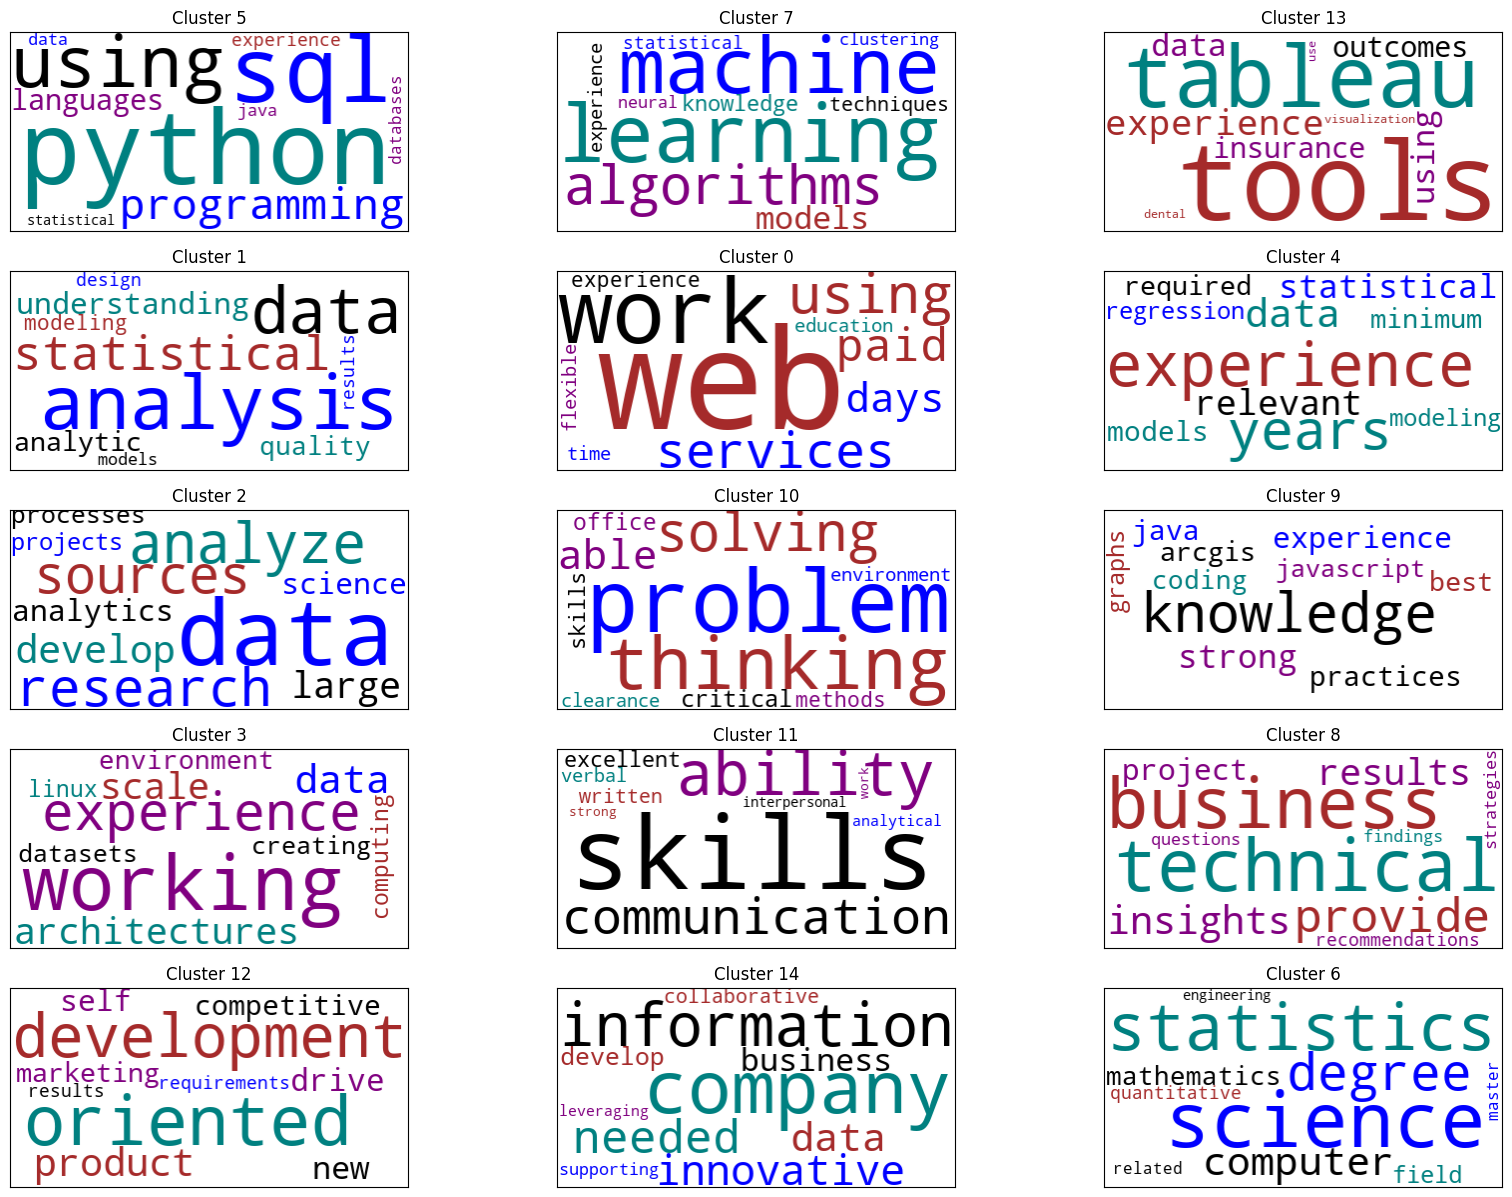

In [ ]:
def sort_cluster_groups(cluster_groups):
    mean_similarities = [compute_mean_similarity(df_cluster)
                         for df_cluster in cluster_groups]

    sorted_indices = sorted(range(len(cluster_groups)),
                            key=lambda i: mean_similarities[i],
                            reverse=True)
    return [cluster_groups[i] for i in sorted_indices]

sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups)
plt.show()

Our hypothesis was right! The first 2 rows within the updated subplot clearly correspond to technical skills. F

### 17.4.2. Investigating the Technical Skill Clusters
Lets turn our attention to the 6 technical-skill cluster within first 2 rows of subplot grid. Below, we’ll re-plot their associated word-clouds in a 2-row by 3-column grid.

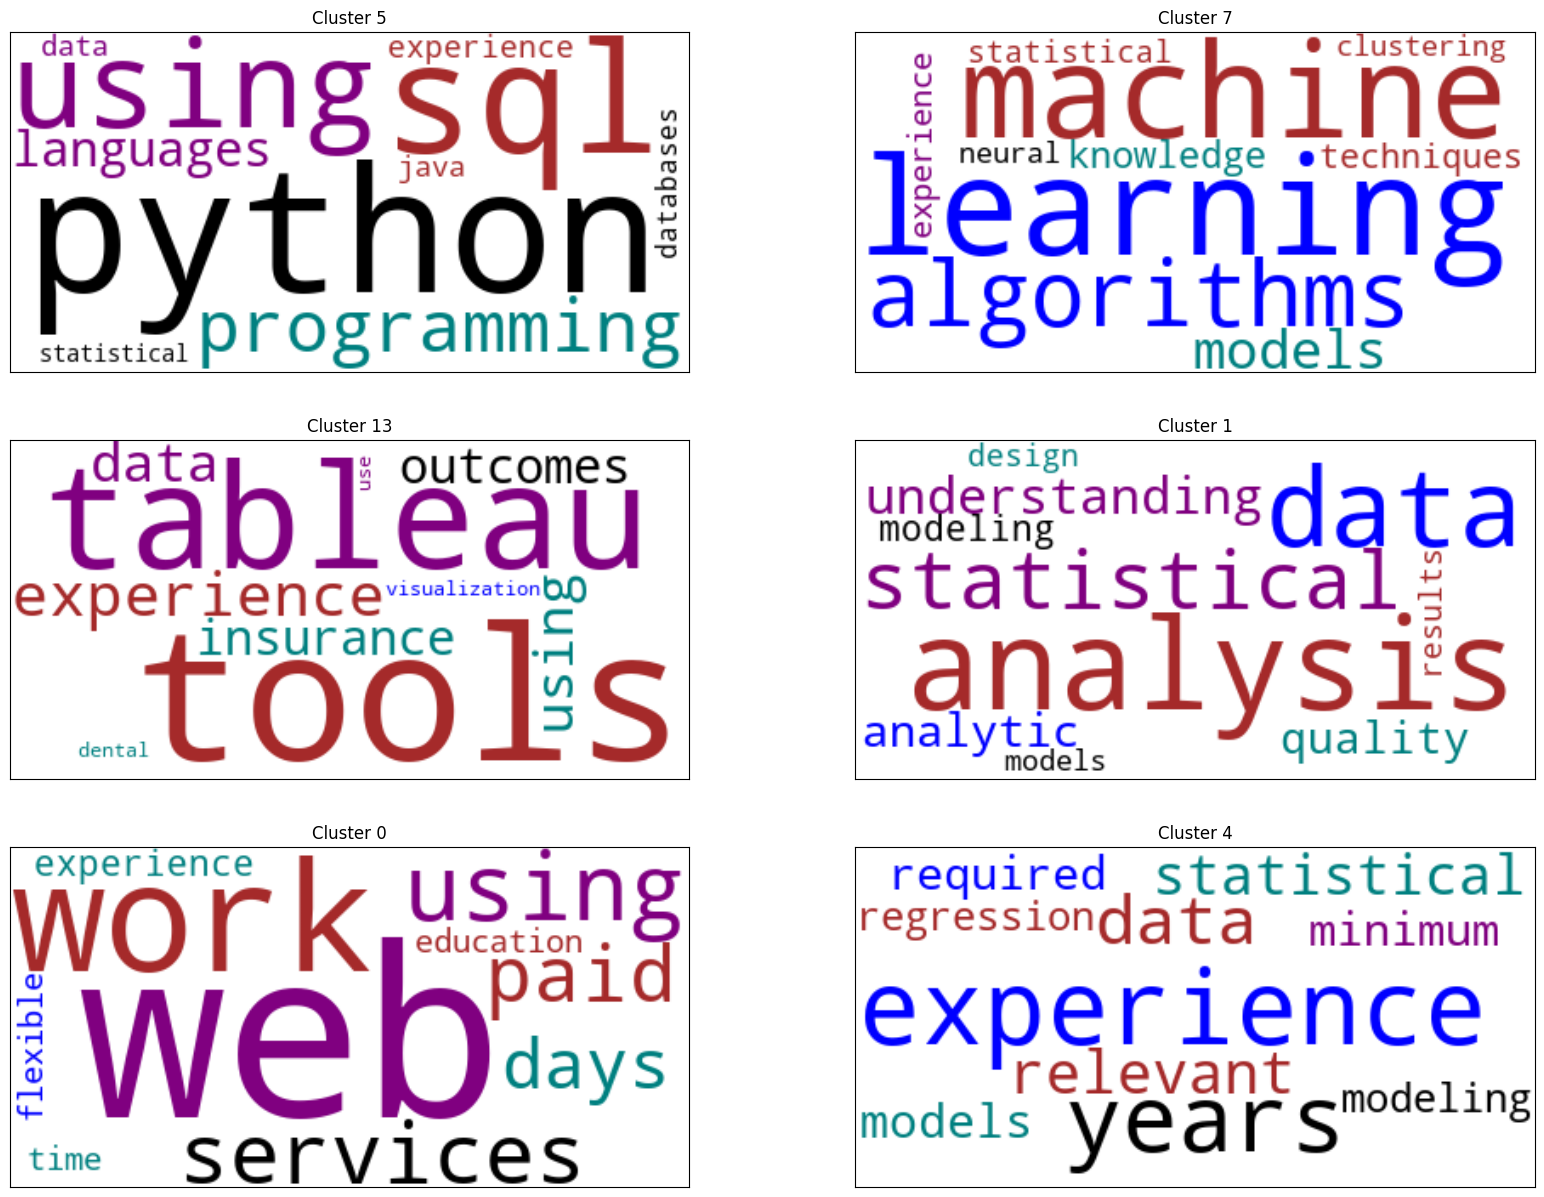

In [ ]:
plot_wordcloud_grid(sorted_cluster_groups[:6], num_rows=3, num_columns=2)
plt.show()

The first 2 rows are insightful. We'll need to brush up on our machine learning skills. However, the final 2 technical-skill clusters appear are vague and uninformative. Below, we’ll sample bullets from these clusters (8 and 1) in order to confirm a lack of pattern.

**Listing 17. 41. Printing sample bullets from Clusters 8 and 1**

In [ ]:
np.random.seed(1)
for cluster_id in [8, 1]:
    print(f'\nCluster {cluster_id}:')
    print_cluster_sample(cluster_id)


Cluster 8:
Guide the technical approach for the design and implementation of successful models and algorithms in support of expert cross-functional teams delivering on demanding projects
Proven ability to drive business results with data-based insights
Research as necessary to provide information to management and the state legislature;
Provide ongoing and high-level advisory technical services to clients and prospective clients
Analyze results and develop technical reports and presentations

Cluster 1:
Work with product managers and data engineers to discover, collect, cleanse, and refine the data needed for analysis and modeling
Intermediate to Expert level proficiency with statistical probabilistic modeling techniques such as regression, tree-based methods (Random Forest, GBM), neural networks, support vector machines, supervised/unsupervised clustering techniques (k-means, DBSCAN, Expectation Maximization), principal component and factor analysis, etc
Using statistical software or

We’ve finished our analysis of the technical-skill clusters. 4 of these clusters were relevant. 2 were not. Now, lets turn our attention to the remaining soft-skill clusters.

### 17.4.3. Investing the Soft-Skill Clusters
We’ll start by visualizing the remaining 9 soft-skill clusters in a 3-row by 3-column grid.

**Listing 17. 42. Plotting the remaining 9 soft-skill clusters**

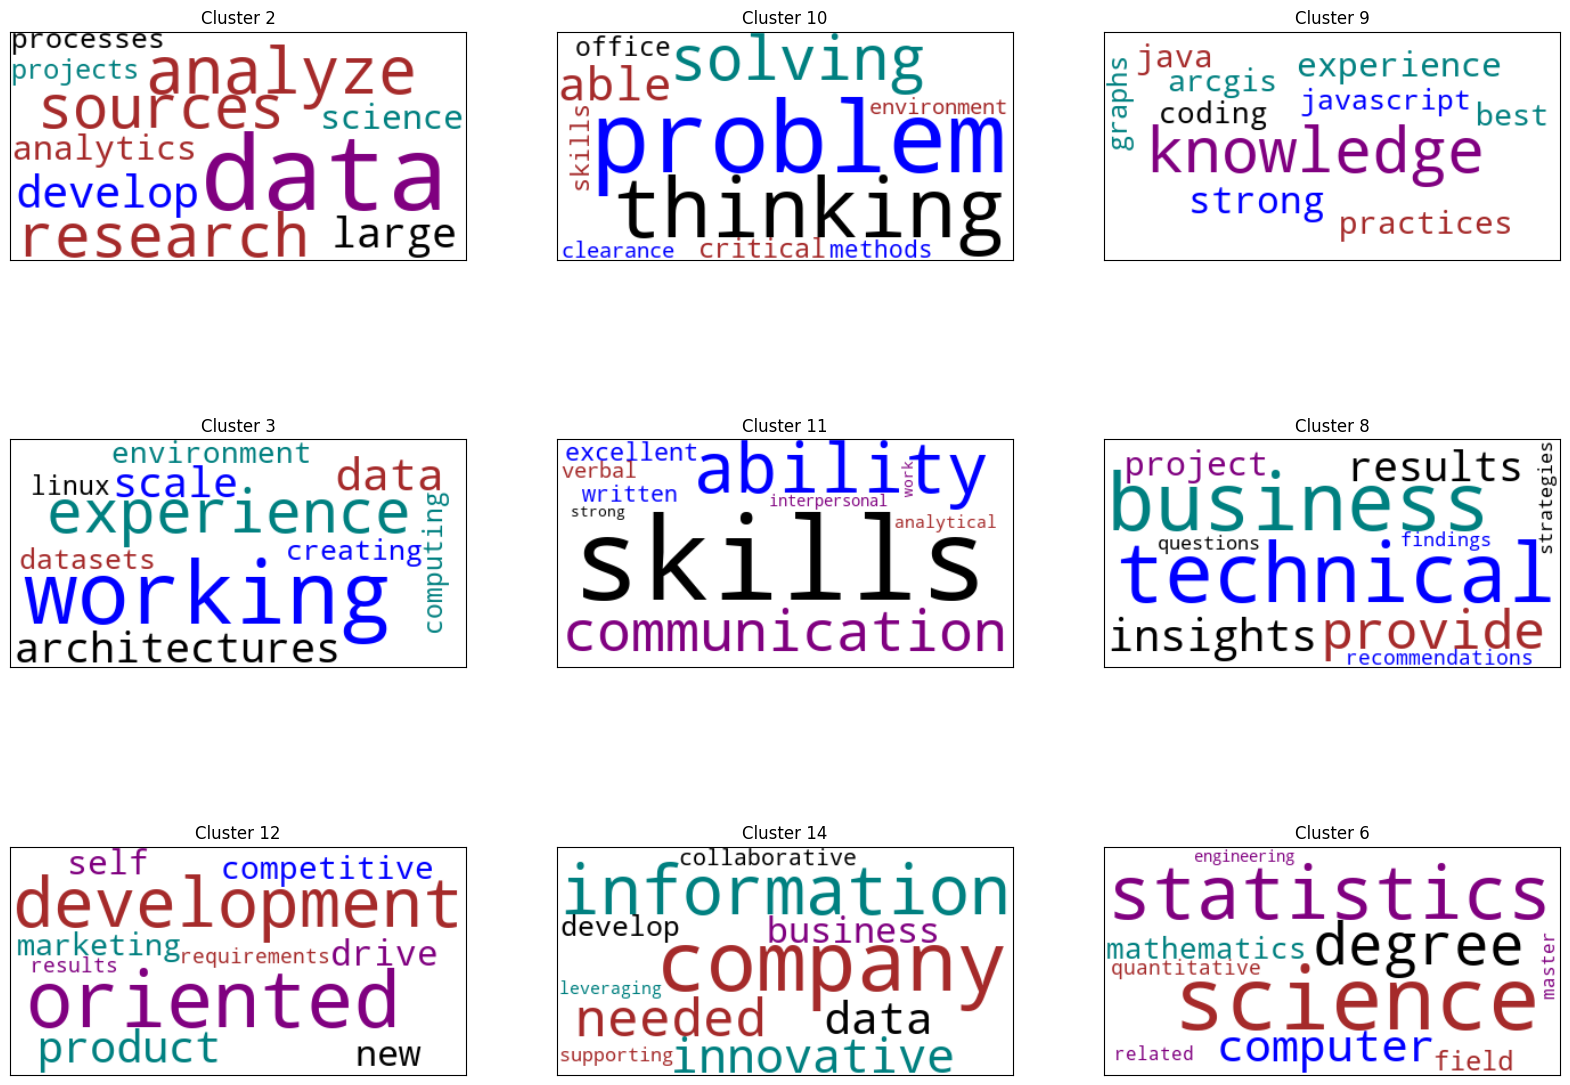

In [ ]:
plot_wordcloud_grid(sorted_cluster_groups[6:], num_rows=3, num_columns=3)
plt.show()

The remaining clusters appear abmbiguous. Also, our soft-skill clusters do not represent true skills! For instance, Cluster 3 (row 0, column 0) consists of bullets requiring a minimal count of years working in industry. Similarly, Cluster 6 (row 2, column 1) represents educational constraints; requiring a quantitative degree to land an interview.

**Listing 17. 43. Printing sample bullets from Clusters 6 and 3**

In [ ]:
np.random.seed(1)
for cluster_id in [6, 3]:
    print(f'\nCluster {cluster_id}:')
    print_cluster_sample(cluster_id)


Cluster 6:
MS in a quantitative research discipline (e.g., Artificial Intelligence, Computer Science, Machine Learning, Statistics, Applied Math, Operations Research)
Master’s degree in data science, applied mathematics, or bioinformatics preferred.
PhD degree preferred
Ph.D. in a quantitative discipline (e.g., statistics, computer science, economics, mathematics, physics, electrical engineering, industrial engineering or other STEM fields)
7+ years of experience manipulating data sets and building statistical models, has advanced education in Statistics, Mathematics, Computer Science or another quantitative field, and is familiar with the following software/tools:

Cluster 3:
Expert working within enterprise data warehouse environments platforms (Teradata, Netezza, Oracle, etc.) and working within distributed computing platforms such as Hadoop and associated technologies such as SQL, HQL, MapReduce, Spark, Storm, Yarn, Kafka, Sqoop and Hive
Facilitate data architecture working sessio

However, one of our soft-skill clusters is very easy to interpret. Cluster 5 (row 0, column 1) focuses on interpersonal communication skills; both written and verbal.


### 17.4.4. Exploring Clusters at Alternative Values of K

Lets we’ll regenerate the clusters using alternative values of K. We’ll begin by setting K to 25, and plotting the results in a 5-row by 5-column grid. The subplots will be sorted based on cluster similarity to our resume.

**Listing 17. 44. Visualizing 25 sorted clusters**

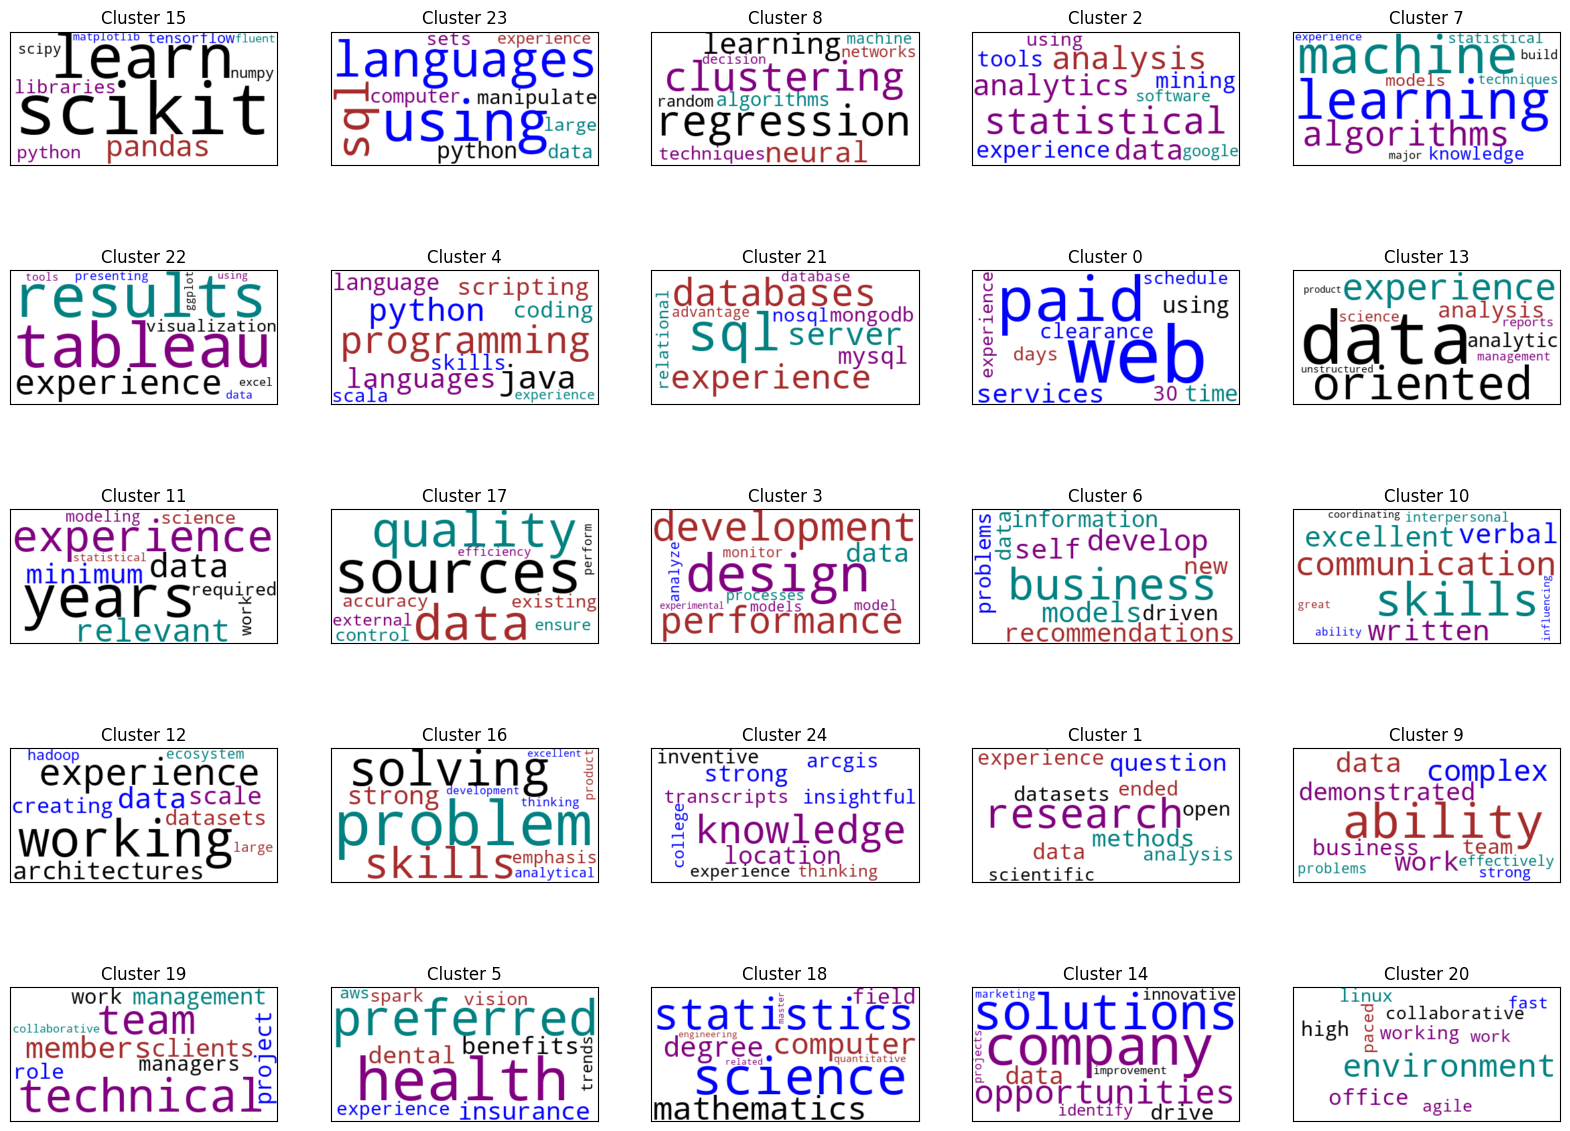

In [ ]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=25)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=5)
plt.show()

Raising K from 15 to 25 has retained all previously-observed insightful clusters. Also, the parameter change has introduced several new interesting clusters (Including Cluster 2: Non-Python Visualization tools and Cluster 23; Databases) Will the stability of these clusters persist if we shift K to an intermediate value of 20? Lets find out.

**Listing 17. 45. Visualizing 20 sorted clusters**

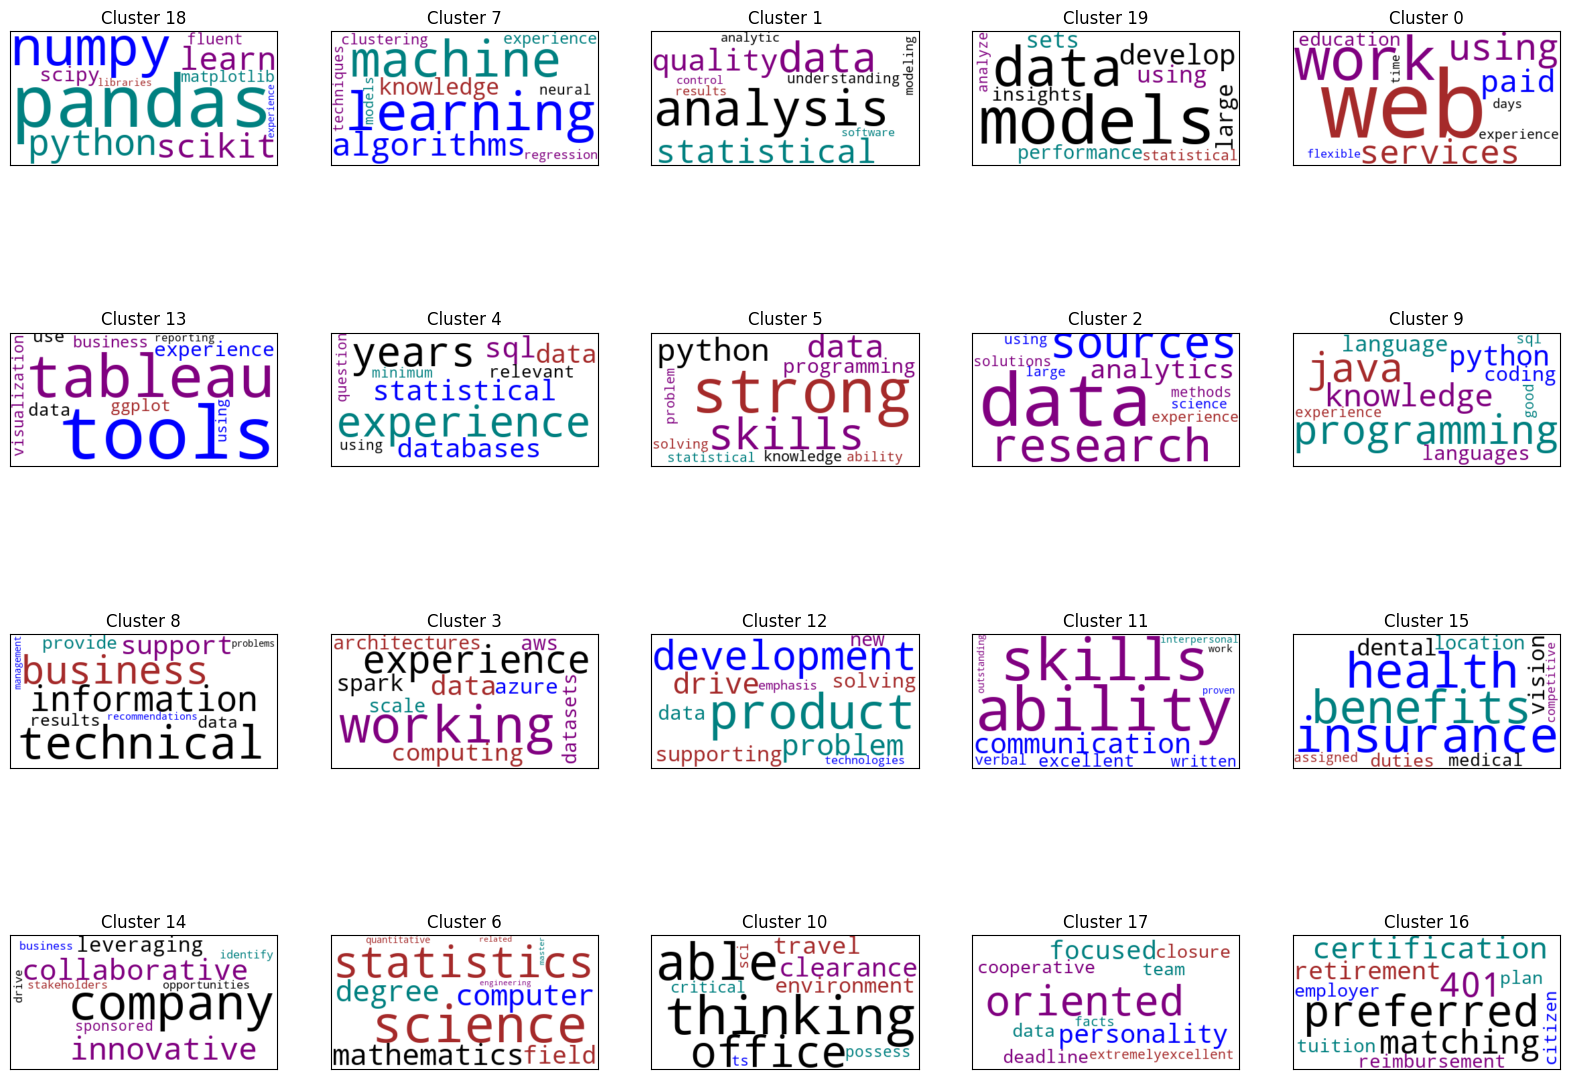

In [ ]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=20)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=4, num_columns=5)
plt.show()

Most of our observed insightful clusters remain at `k=20`. However, the statistical analysis cluster observed at K-values of 15 and 25 is currently missing. If we cluster over just a single value of K, we risk missing out on useful insights. Thus, it’s preferable to visualize results over a range of K-values during text analysis. With this in mind, lets see what happens when we drop K to 10.

**Listing 17. 46. Visualizing 10 sorted clusters**

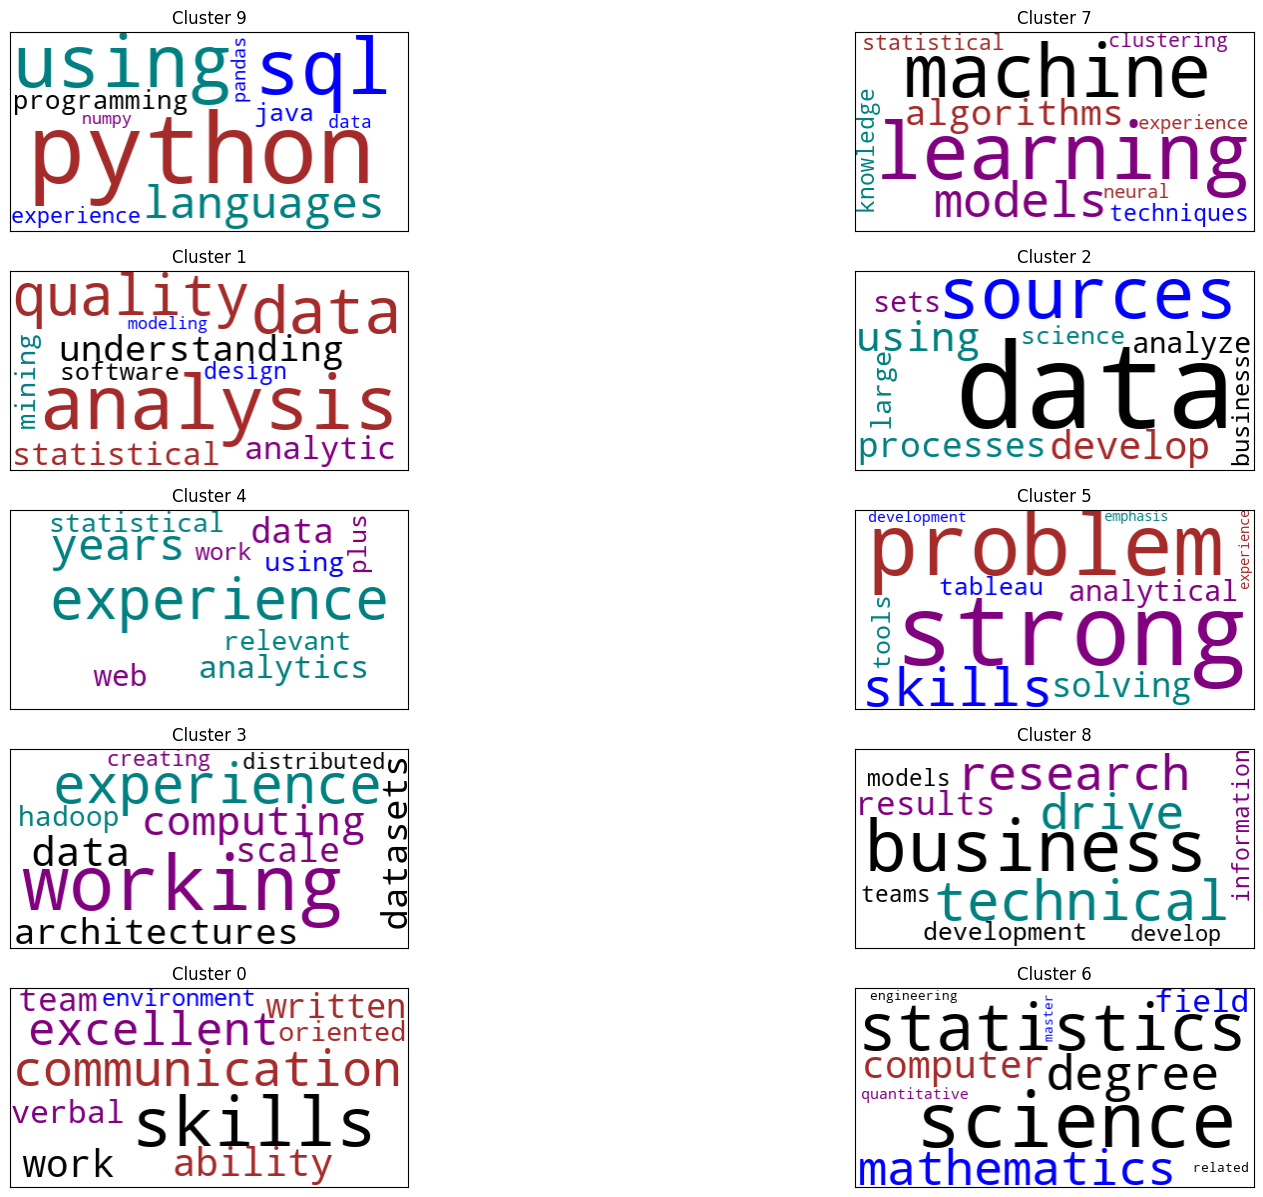

In [ ]:
np.random.seed(0)
cluster_groups = compute_cluster_groups(shrunk_norm_matrix, k=10)
sorted_cluster_groups = sort_cluster_groups(cluster_groups)
plot_wordcloud_grid(sorted_cluster_groups, num_rows=5, num_columns=2)
plt.show()

The 10 visualized clusters are quite limited. Nonetheless, 4 of the 10 clusters contain the critical skills we’ve previously observed. These include Python programming (row 0, column 0), machine learning (row 0, column 1), and communication skills (row 2, column 1). Also, the statistical analysis cluster has reappered (row 1, column 0).
Surprisingly, some of our skill-clusters are quite versatile.

So far, our observations have been limited to the 60 most relevant job postings. What will happen if we extand our analysis to the top 700 postings?  We’ll now find out.

### 17.4.5. Analyzing the 700 Most-Relevant Postings

We’ll start by preparing `sorted_df_jobs[:700].Bullets` for clustering.

**Listing 17. 47. `Preparing sorted_df_jobs[:700]` for clustering analysis**

In [ ]:
np.random.seed(0)
total_bullets_700 = set()
for bullets in sorted_df_jobs[:700].Bullets:
    total_bullets_700.update([bullet.strip()
                              for bullet in bullets])

total_bullets_700 = sorted(total_bullets_700)
vectorizer_700 = TfidfVectorizer(stop_words='english')
tfidf_matrix_700 = vectorizer_700.fit_transform(total_bullets_700)
shrunk_norm_matrix_700 = shrink_matrix(tfidf_matrix_700)
print(f"We've vectorized {shrunk_norm_matrix_700.shape[0]} bullets")

We've vectorized 10194 bullets


We’ve vectorized 10,194 bullet-points. Now, we’ll generate an Elbow plot across the vectorized results. Based on previous observations, we don’t expect the Elbow plot to be particularly informative.

**Listing 17. 48. Plotting an elbow curve for 10,194 bullets**

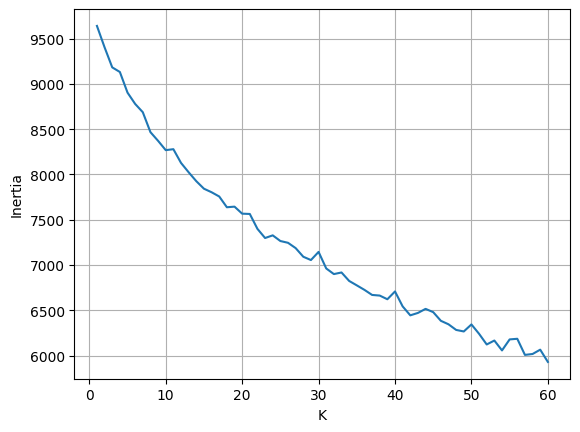

In [ ]:
np.random.seed(0)
generate_elbow_plot(shrunk_norm_matrix_700)

As expected, the precise location of the elbow is not clear within the plot. The elbow is spread out between a K of 10 and 25. We’ll deal with ambiguity, by arbitrarily setting K to 20.

**WARNING: As we discussed in Section Fifteen, the K-means outputs could vary across computers for large matrices containing 10,000-by-100 elements. Thus, your local clustering results might differ from the output seen below. Nonetheless, you should be able to draw similar conclusions to the ones presented in this book.**

**Listing 17. 49. Visualizing 20 sorted clusters for 10,194 bullets**

In [ ]:
def compute_cluster_groups(shrunk_norm_matrix, k=15):
    cluster_model = KMeans(n_clusters=k)
    clusters = cluster_model.fit_predict(shrunk_norm_matrix)
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': total_bullets_700})  # change total_bullets into total_bullets_700
    return [df_cluster for  _, df_cluster in df.groupby('Cluster')]

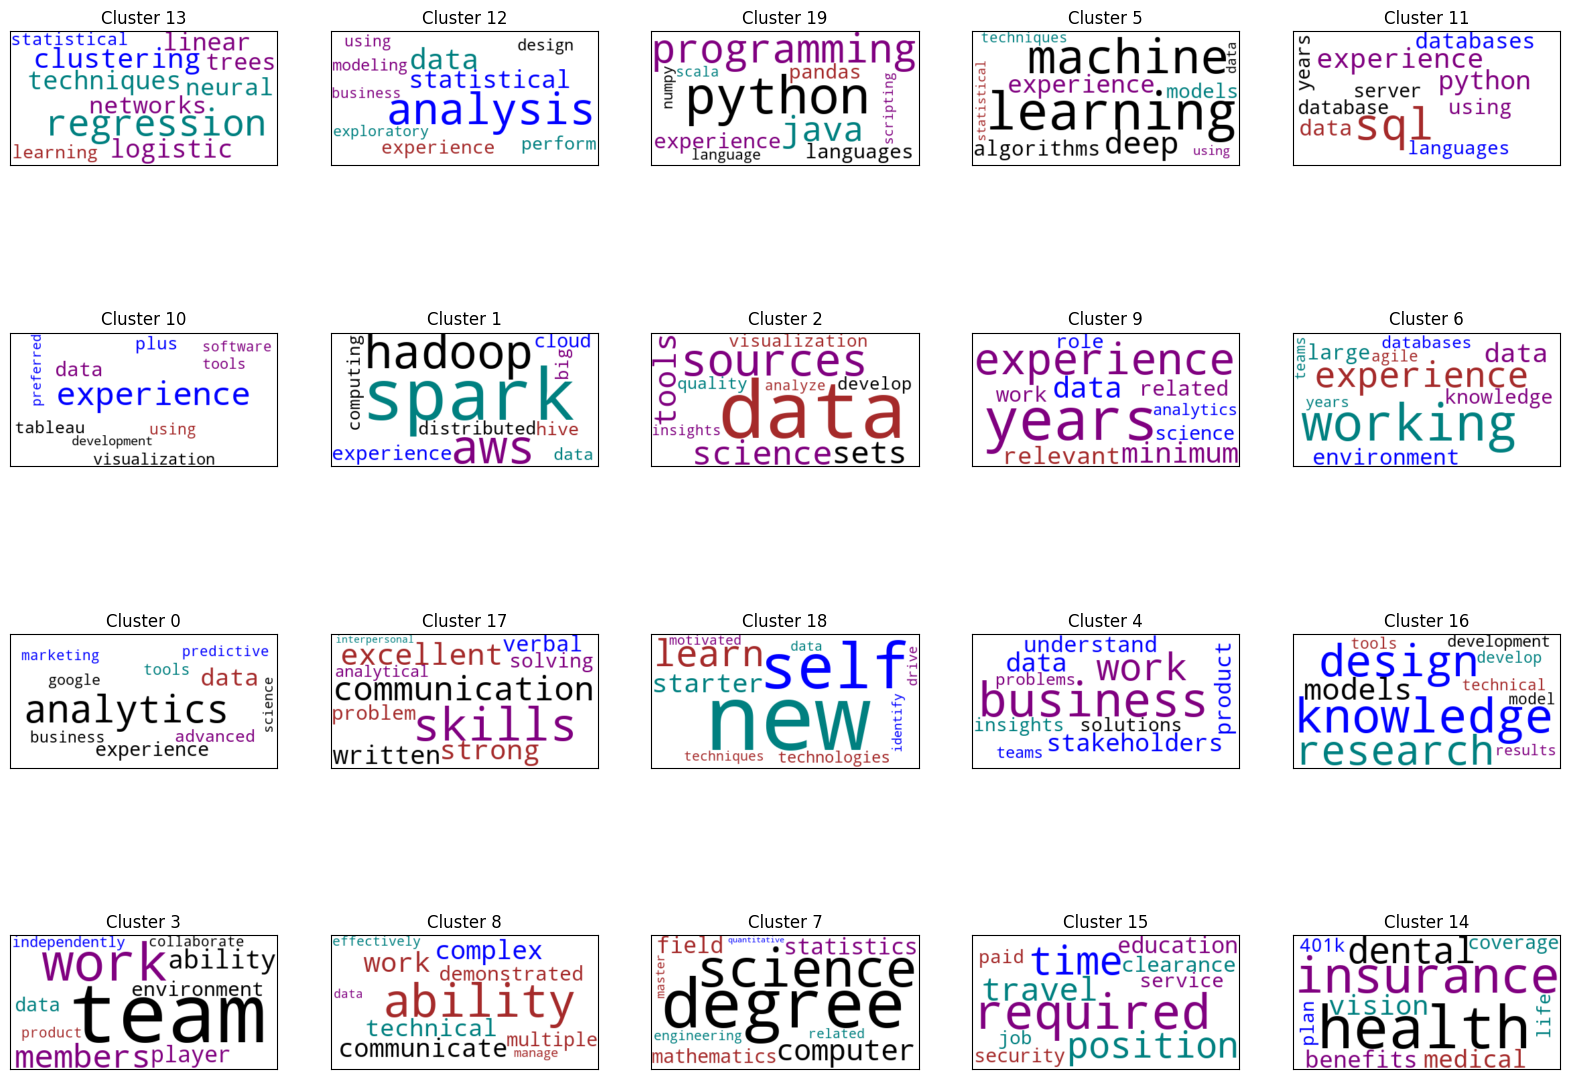

In [ ]:
np.random.seed(0)
cluster_groups_700 = compute_cluster_groups(shrunk_norm_matrix_700, k=20)
bullet_cosine_similarities = compute_bullet_similarity(total_bullets_700)
sorted_cluster_groups_700 = sort_cluster_groups(cluster_groups_700)
plot_wordcloud_grid(sorted_cluster_groups_700, num_rows=4, num_columns=5,
                    vectorizer=vectorizer_700, tfidf_matrix=tfidf_matrix_700)


Our clustering output looks very similar to what we’ve seen before. The key insightful clusters we’ve observed at 60 postings still remain.

---

# III. Additional Task: The field other than data science

At this part, we focus on the required skills of **Non-Data-Science Jobs(NDSJ)**. According to analysis at the begining, our job list data contains some Nursing-related & Management-related jobs. Here we explore the job concerning Nursing

## Step1. Data Mining

#### 1(a) We first selecting all the jobs containing *"Nurse or Nursing"*

In [ ]:
# restore the data frame to the stage that we only know the title, body and bullet
df_jobs = df_jobs.iloc[:, 0:3]
df_jobs.head(2)

Title  \
0    Data Scientist - Beavercreek, OH   
1  Data Scientist - Seattle, WA 98101   

                                                Body  \
0  Data Scientist - Beavercreek, OH\nData Scienti...   
1  Data Scientist - Seattle, WA 98101\nAre you in...   

                                             Bullets  
0  [Use statistical research methods to analyze d...  
1  [Interface with our internal engagement teams ...

In [ ]:
# select jobs having 'Nursing' in title
regex = r'Nurs(e|ing)'
df_nursing_jobs = df_jobs[df_jobs['Title'].str.contains('Nurse|Nursing', case=False, na=False)]
df_nursing_jobs.head()

Title  \
73    Certified Nursing Assistant PCA - Mesa, AZ 85206   
226  Nursing Assist,ICU/CCU,15117,36 hrs-7a-7:30p,E...   
466  Certified Nursing Assistant PCA PCU Surgical -...   
759                                Nurse RN - Cary, NC   
820  Staff Nurse II - Medical/Surgical-Day-Benefitt...   

                                                  Body  \
73   Certified Nursing Assistant PCA - Mesa, AZ 852...   
226  Nursing Assist,ICU/CCU,15117,36 hrs-7a-7:30p,E...   
466  Certified Nursing Assistant PCA PCU Surgical -...   
759  Nurse RN - Cary, NC\nNurse RN\nCary, NC\nVein ...   
820  Staff Nurse II - Medical/Surgical-Day-Benefitt...   

                                               Bullets  
73   [Provides assistance in activities of daily li...  
226                                                 []  
466  [Provides assistance in activities of daily li...  
759  [Assist the Physician with treatment of all pa...  
820  [Clinical Knowledge, Demonstrates an understan...

#### 1(b) Recall the real part we conduct analysis is the contents from bullet points. Next we extract all bullet points required in Nurse-related jobs and eliminate duplication.

In [ ]:
# Prepare the part of data that we are really interested: bullet points
nursing_bullets = []
for bullets in df_nursing_jobs.Bullets:
    nursing_bullets.extend(bullets)

nursing_bullets = sorted(set(nursing_bullets)) #set() automaticaly eliminates duplication
len(nursing_bullets)

106

Thus we have 106 unique bullet points asking Nursing-ralated skills. These are the data we want to apply analysis.

## Step2. Dimention Reduction

#### 2(a) Fundimental Principle is using information from TF-IDF

In [ ]:
vectorizer_N = TfidfVectorizer(stop_words='english')
tfidf_matrix_N = vectorizer_N.fit_transform(nursing_bullets)
num_rows, num_columns = tfidf_matrix_N.shape
print(f"Our matrix has {num_rows} rows and {num_columns} columns")

Our matrix has 106 rows and 606 columns


Size of TF-IDF matrix is a little bit large, so we consider dimention reduction.

#### 2(b) SVD

In [ ]:
np.random.seed(0)

# redefine the shrink function since we don't need n_components to be that large(previously 100 is used)
def shrink_matrix(tfidf_matrix):
    svd_object = TruncatedSVD(n_components=20)
    shrunk_matrix = svd_object.fit_transform(tfidf_matrix)
    return normalize(shrunk_matrix)

shrunk_norm_matrix_N = shrink_matrix(tfidf_matrix_N)

Now we have a 106x20 matrix as our input. Looks reasonable.

## Step3. Clustering & Visualization

#### 3(a) Clustering by K-means Algorithm

In [ ]:
np.random.seed(0)

def compute_cluster_groups(data, k=15):
    cluster_model = KMeans(n_clusters=k)
    clusters = cluster_model.fit_predict(data)
    df = pd.DataFrame({'Index': range(clusters.size), 'Cluster': clusters,
                       'Bullet': nursing_bullets})                          # change into nursing_bullets
    return [df_cluster for  _, df_cluster in df.groupby('Cluster')]

cluster_groups = compute_cluster_groups(shrunk_norm_matrix_N)

#### 3(b) Cloud Plots of Each Cluster

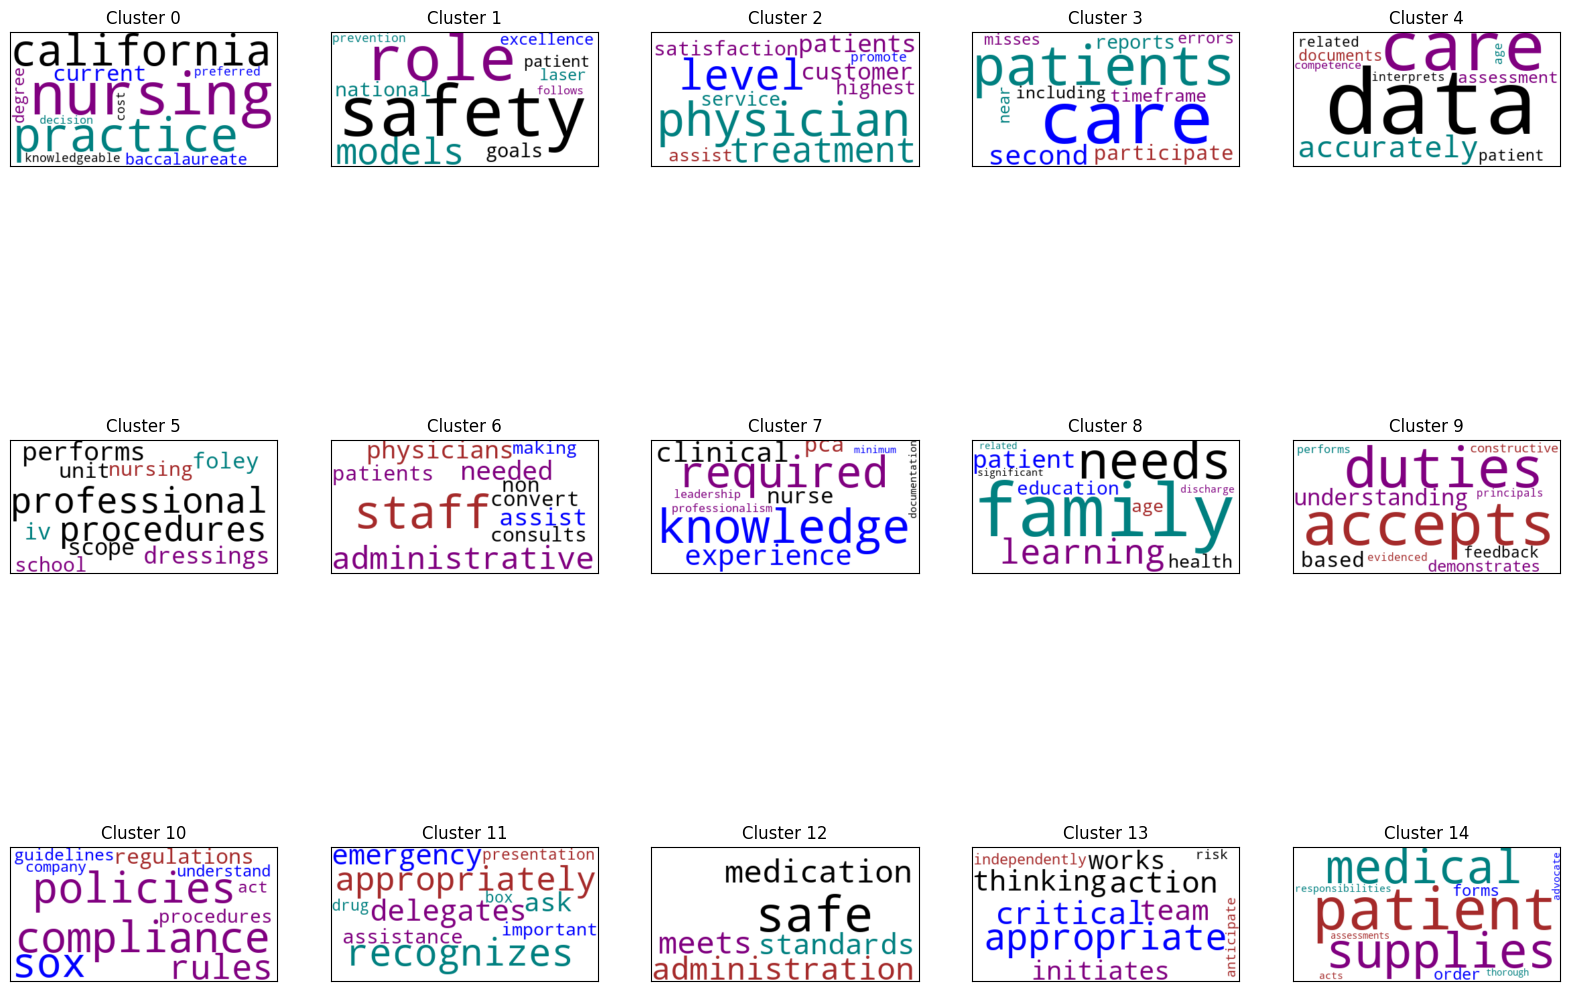

In [ ]:
plot_wordcloud_grid(cluster_groups, num_rows=3, num_columns=5,
                    vectorizer=vectorizer_N, tfidf_matrix=tfidf_matrix_N)


## Introduction to TF-IDF

Term Frequency-Inverse Document Frequency (TF-IDF) is a statistical measure commonly used in information retrieval and text mining to evaluate the importance of a word in a document relative to a collection of documents (corpus). TF-IDF is widely used in text-based applications, including search engines, document classification, and recommendation systems. It aims to highlight words that are relevant to specific documents while reducing the influence of frequently occurring, less informative words like common stop words.

### What is TF-IDF?

TF-IDF is the product of two terms: **Term Frequency (TF)** and **Inverse Document Frequency (IDF)**.

- **TF (Term Frequency)**: It measures how frequently a term (word) appears in a document. The assumption is that the more times a word appears, the more relevant it is within the document. The formula for TF is:

$$
\text{TF}(t, d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
$$

- **IDF (Inverse Document Frequency)**: It measures how important a term is within the entire corpus. Words that appear in many documents are considered less informative. The formula for IDF is:

$$
\text{IDF}(t) = \log \left( \frac{N}{df(t)} \right)
$$

Where:
- \( N \) is the total number of documents in the corpus.
- \( df(t) \) is the number of documents containing the term \( t \).

### TF-IDF Formula

The TF-IDF value of a term \( t \) in document \( d \) is simply the product of the TF and IDF scores:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

This gives us a weighted value that reflects both the frequency of the term within the document and its rarity in the entire corpus. Terms that are frequent in a document but rare across the corpus will have high TF-IDF values.

### Importance of TF-IDF

- **Identifying Relevant Terms**: TF-IDF helps identify words that are significant to individual documents but not common across the entire corpus. For instance, the word "banana" in a document about fruits would have a high TF-IDF score, while in a document about common fruits, it would have a low score.
- **Reducing Noise**: Common terms like "and", "the", "is", etc., are often not very useful for differentiating documents, and TF-IDF helps downweight these common terms by lowering their IDF value.

### Steps for Using TF-IDF

1. **Compute Term Frequency (TF)**: For each document, calculate how frequently each word appears relative to the total number of words in that document.
2. **Compute Inverse Document Frequency (IDF)**: For each word, compute how frequently it appears across all documents and calculate its inverse document frequency.
3. **Calculate TF-IDF**: Multiply the TF and IDF values for each term to get the TF-IDF score. This score helps to rank the importance of words within a document in relation to the corpus.

### Applications of TF-IDF

- **Search Engines**: TF-IDF is widely used in search engines to rank documents based on their relevance to a given query. Higher TF-IDF scores for terms in a query correspond to more relevant documents.
- **Document Classification**: TF-IDF is useful in text classification tasks, where documents are categorized into predefined labels based on the presence of certain terms.
- **Recommendation Systems**: TF-IDF can be applied in systems recommending articles, products, or media based on text content analysis.

### Conclusion

TF-IDF is a powerful and intuitive measure for evaluating the significance of terms in text data. It balances the frequency of terms within individual documents and their distribution across the entire corpus, providing a nuanced understanding of text content. This makes TF-IDF a crucial tool in a wide range of text mining applications, from search engines to content analysis and beyond.

# IV. Statistical Concepts: SVD

## Introduction to Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a technique used in various fields, including data science, machine learning, and statistics, for dimensionality reduction, data compression, and noise reduction. SVD is particularly useful when dealing with large datasets, where traditional methods like Principal Component Analysis (PCA) may face challenges due to computational complexity or sensitivity to measurement units.

### What is SVD?

SVD decomposes a given matrix \( A \) into three components:

\[ A = U Σ V^T \]

- **U**: An orthogonal matrix whose columns are the left singular vectors.
- **Σ (Sigma)**: A diagonal matrix containing singular values, which represent the strength of each corresponding singular vector.
- **V^T**: The transpose of an orthogonal matrix whose columns are the right singular vectors.

### Connection to PCA

While PCA focuses on maximizing variance and requires centering the data, SVD provides a more flexible approach. SVD does not necessarily require mean subtraction, making it less sensitive to floating-point precision errors often encountered in PCA. This is particularly beneficial when working with datasets that are already close to the mean.

### Calculation of Principal Components

SVD can be used to extract principal components by interpreting the singular values and vectors. The left singular vectors (from matrix \( U \)) correspond to the principal components of the dataset, while the singular values indicate the importance of these components. By projecting the original data onto these vectors, we can achieve a lower-dimensional representation of the data.

### Steps for Using SVD

1. **Decompose the Data Matrix**: Perform SVD on the centered or original data matrix, breaking it down into three components. Each of these components represents important features of the data.
2. **Select Components**: Choose the top \( k \) singular values and the corresponding vectors from \( U \) and \( V \). These selected components represent the most significant features of the data.
3. **Transform the Data**: Transform the original data into a reduced space using the selected components. By selecting a limited number of singular values and vectors, we can effectively reduce the dimensionality and achieve data compression.

### Conclusion

SVD is a more flexible matrix decomposition method that can reduce dimensionality, compress data, and also remove noise.

# V. Statistical Cocepts: K-means

## Introduction to K-means Clustering

K-means clustering is a widely used unsupervised learning algorithm in data science and machine learning for partitioning a dataset into distinct groups or clusters. It is particularly effective for exploratory data analysis, pattern recognition, and image segmentation. K-means is known for its simplicity and efficiency, making it a popular choice for clustering tasks.

### What is K-means?

K-means aims to partition \( n \) data points into \( k \) clusters, where each data point belongs to the cluster with the nearest mean (centroid). The algorithm minimizes the within-cluster variance, which is defined mathematically as:

$$
J = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - \mu_i \|^2
$$

where:
- $ J $ is the objective function (total variance).
- $C_i$ is the set of points in cluster $ i $.
- $\mu_i$ is the centroid of cluster $ i $.
- $|| x - \mu_i \|^2 $ is the squared Euclidean distance between a data point $ x $ and the centroid $ \mu_i $.

### The K-means Algorithm

The K-means algorithm consists of the following steps:

1. **Initialization**: Choose $ k $ initial centroids randomly from the dataset.
2. **Assignment Step**: Assign each data point to the nearest centroid, forming $ k $ clusters. The assignment can be expressed as:

$$
C_i = \{ x_j : \| x_j - \mu_i \|^2 < \| x_j - \mu_m \|^2 \, \forall m \neq i \}
$$

where $ C_i $ is the set of points assigned to cluster $ i $, and $ x_j $ are the data points.
  
3. **Update Step**: Recalculate the centroids of the clusters by taking the mean of all points assigned to each cluster:

$$
\mu_i = \frac{1}{|C_i|} \sum_{x_j \in C_i} x_j
$$

4. **Convergence Check**: Repeat steps 2 and 3 until the centroids no longer change significantly or a predefined number of iterations is reached.

### Choosing the Number of Clusters $ k $

Selecting the appropriate number of clusters $ k $ is crucial for the performance of the K-means algorithm. Common methods for determining $ k $ include:

- **Elbow Method**: Plotting the total within-cluster variance $ J $ against different values of $ k $ and looking for an "elbow" point where the rate of decrease sharply changes.
- **Silhouette Score**: Measuring how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters.

### Conclusion

K-means clustering is a powerful and efficient method for partitioning data into clusters based on similarity. Its simplicity, ease of implementation, and scalability make it a go-to choice for many clustering tasks in various domains. However, it is important to note that K-means assumes spherical clusters and is sensitive to the initial placement of centroids, which can affect the final clustering results.




# VI. Statistical Concepts: Text Vectorization Methods - TF-IDF

Term Frequency-Inverse Document Frequency (TF-IDF) is a fundamental statistical method used in information retrieval and text mining to evaluate the importance of a word in a document relative to a collection of documents (corpus). It is widely used in various text-based applications, including search engines, document classification, and recommendation systems.



### What is TF-IDF?

TF-IDF is the product of two terms: **Term Frequency (TF)** and **Inverse Document Frequency (IDF)**.

- **TF (Term Frequency)**: Measures how frequently a term (word) appears in a document. The assumption is that the more times a word appears, the more relevant it is within the document. The formula for TF is:

$$
\text{TF}(t, d) = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}}
$$

- **IDF (Inverse Document Frequency)**: Measures how important a term is within the entire corpus. Words that appear in many documents are considered less informative. The formula for IDF is:

$$
\text{IDF}(t) = \log \left( \frac{N}{df(t)} \right)
$$

Where:
- \( N \) is the total number of documents in the corpus.
- \( df(t) \) is the number of documents containing the term \( t \).

### TF-IDF Formula

The TF-IDF value of a term \( t \) in document \( d \) is simply the product of the TF and IDF scores:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

This weighted value reflects both the frequency of the term within the document and its rarity in the entire corpus. Terms that are frequent in a document but rare across the corpus will have high TF-IDF values.

### Importance of TF-IDF

- **Identifying Relevant Terms**: TF-IDF helps identify words that are significant to individual documents but not common across the entire corpus.
- **Reducing Noise**: Common terms like "and", "the", "is", etc., are often not very useful for differentiating documents, and TF-IDF helps downweight these common terms by lowering their IDF value.

### Steps for Using TF-IDF

1.  **Compute Term Frequency (TF)**: For each document, calculate how frequently each word appears relative to the total number of words in that document.
2.  **Compute Inverse Document Frequency (IDF)**: For each word, compute how frequently it appears across all documents and calculate its inverse document frequency.
3.  **Calculate TF-IDF**: Multiply the TF and IDF values for each term to get the TF-IDF score. This score helps to rank the importance of words within a document in relation to the corpus.

### Python Code Example


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample sentences
sample_documents = [
    "Data science is an interdisciplinary field.",        # Doc 0: General statement about data science
    "Machine learning is a subset of artificial intelligence.", # Doc 1: General statement about ML
    "Data mining is used to discover patterns in large datasets.", # Doc 2: General statement about data mining
    "A data scientist uses Python and machine learning.",    # Doc 3: Specific skills of a data scientist
    "An AI engineer works with neural networks and deep learning.", # Doc 4: Specific skills of an AI engineer
    "The cat sat on the mat.",                         # Doc 5: Unrelated sentence
    "The feline perched on the rug."                      # Doc 6: Semantically similar to Doc 5, but different words
]

# Create TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the sample documents
tfidf_matrix = vectorizer_tfidf.fit_transform(sample_documents)

# Calculate cosine similarity matrix
cosine_sim_tfidf = cosine_similarity(tfidf_matrix)

# Convert to DataFrame for better readability
df_tfidf_sim = pd.DataFrame(cosine_sim_tfidf, index=range(len(sample_documents)), columns=range(len(sample_documents)))
print("TF-IDF Cosine Similarity Matrix:\n", df_tfidf_sim)

TF-IDF Cosine Similarity Matrix:
           0         1         2         3         4    5    6
0  1.000000  0.000000  0.105469  0.124118  0.000000  0.0  0.0
1  0.000000  1.000000  0.000000  0.268754  0.096413  0.0  0.0
2  0.105469  0.000000  1.000000  0.091098  0.000000  0.0  0.0
3  0.124118  0.268754  0.091098  1.000000  0.091098  0.0  0.0
4  0.000000  0.096413  0.000000  0.091098  1.000000  0.0  0.0
5  0.000000  0.000000  0.000000  0.000000  0.000000  1.0  0.0
6  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  1.0


## Interpretation of the TF-IDF Matrix

The TF-IDF matrix represents the importance of each word in each document. Each row corresponds to a document, and each column corresponds to a unique word in the corpus. The values in the matrix are the TF-IDF scores for each word in each document.

For example, let's look at the first row:

- The word "data" has a TF-IDF score of 0.40204 in the first document.
- The word "science" has a TF-IDF score of 0.528635 in the first document.
- The word "interdisciplinary" has a TF-IDF score of 0.528635 in the first document.

This indicates that the words "data," "science," and "interdisciplinary" are important for the first document, while other words are less relevant.

### Limitations of TF-IDF

While TF-IDF is a valuable technique, it has several limitations:

- **Lack of Semantic Understanding**: TF-IDF treats words as independent units and does not capture semantic relationships between words. For example, "data scientist" and "data analyst" are treated as completely different terms, even though they are semantically related.

- **Sensitivity to Stop Words**: Requires careful handling of stop words (common words like "the," "and," "is") to avoid skewing results. Although we used `stop_words='english'` in the example, the effectiveness of this built-in list may vary.

- **Vocabulary Dependence**: TF-IDF can only compare documents that share some vocabulary. If two documents do not have any words in common, their similarity will be zero, even if they are semantically similar.

- **Ignores Word Order**: TF-IDF ignores the order of words in a document, which can be important for understanding the meaning of the text.

- **Term Frequency Bias**: TF-IDF can be biased towards longer documents, as they are more likely to have higher term frequencies.

To overcome these limitations, more advanced text vectorization methods have been developed, such as **Sentence Transformers** and **OpenAI Embeddings**, which leverage deep learning models to capture the semantic meaning of text. These methods will be explored in the next section.

# VII. Text Vectorization Extension

In the previous section, we explored TF-IDF as a fundamental text vectorization method. While TF-IDF is useful for many applications, it has limitations in capturing semantic meaning and handling complex language structures. To address these shortcomings, we introduce two advanced text vectorization techniques: Sentence Transformers and OpenAI Embeddings.



## A. Sentence Transformers

Sentence Transformers are a family of pre-trained deep learning models designed to generate high-quality sentence embeddings. These models are based on the Transformer architecture, which has proven highly effective in various natural language processing tasks.

### Key Concepts:

-   **Embeddings:** Dense, fixed-size vectors that represent words or sentences. Unlike TF-IDF, the dimensionality is not tied to the vocabulary size.
-   **Contextualization:** The embedding for a word depends on its *context* – the surrounding words.
-   **Semantic Similarity:** Words or sentences with similar meanings will have embeddings that are close together in the vector space (as measured by cosine similarity).
-   **Pre-trained Models:** Sentence Transformers leverage models like BERT, RoBERTa, and others that have been trained on enormous datasets.

### Python Code Example:

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load pre-trained Sentence Transformer model
model_st = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the sample documents
embeddings_st = model_st.encode(sample_documents, convert_to_tensor=True)

# Calculate cosine similarity matrix
cosine_sim_st = util.cos_sim(embeddings_st, embeddings_st)

# Convert to DataFrame for better readability
df_st_sim = pd.DataFrame(cosine_sim_st.cpu().numpy(), index=range(len(sample_documents)), columns=range(len(sample_documents)))

print("Sentence Transformers Cosine Similarity Matrix:\n", df_st_sim)

Sentence Transformers Cosine Similarity Matrix:
           0         1         2         3         4         5         6
0  1.000000  0.415820  0.433555  0.567937  0.275927  0.023233 -0.019571
1  0.415820  1.000000  0.449353  0.540300  0.474138 -0.085081 -0.066941
2  0.433555  0.449353  1.000000  0.472098  0.162749 -0.057703 -0.029898
3  0.567937  0.540300  0.472098  1.000000  0.517009 -0.013600 -0.011228
4  0.275927  0.474138  0.162749  0.517009  1.000000 -0.040932 -0.024963
5  0.023233 -0.085081 -0.057703 -0.013600 -0.040932  1.000000  0.555588
6 -0.019571 -0.066941 -0.029898 -0.011228 -0.024963  0.555588  1.000000


### Explanation of Sentence Transformer Results:
The code calculates the cosine similarity between the sentence embeddings generated by the Sentence Transformer model. Let's analyze the results in df_st_sim:

**Diagonal (Self-Similarity):** The diagonal elements are all 1.0, as expected. Each sentence is perfectly similar to itself.

**Doc 0, 1, 2 (Data Science, ML, Data Mining):** These sentences have relatively high similarity scores with each other (around 0.3 to 0.5). This is because they all relate to the general field of data science. Notice that these scores are higher than the corresponding TF-IDF scores, demonstrating the Sentence Transformer's ability to capture semantic relationships.

**Doc 3 & Doc 4 (Data Scientist & AI Engineer):** These sentences have a high similarity score (around 0.48). Sentence Transformers correctly identify that these roles, while distinct, are closely related within the broader field of AI/data science.

**Doc 5 & Doc 6 (Cat & Feline):** This is the most crucial comparison. These sentences have very different words, but very similar meanings. The Sentence Transformer gives them a high similarity score (around 0.69), while TF-IDF gives them a score of zero. This highlights the core advantage of Sentence Transformers: they understand meaning, not just word overlap.

**Doc 5/6 vs. Others:** The cat sentences have low similarity to the data science sentences, as expected.

### Comparison to TF-IDF:

The Sentence Transformer consistently outperforms TF-IDF in capturing semantic similarity. It recognizes the relatedness of data science terms and, most strikingly, the similarity between the "cat" and "feline" sentences, where TF-IDF fails completely.

## B. OpenAI Embeddings
OpenAI provides access to its powerful language models through an API. These models can generate high-quality embeddings that often outperform Sentence Transformers, especially on complex or nuanced text.

### Key Concepts:
- **State-of-the-Art Models:** OpenAI's models have been trained on vast amounts of text data, resulting in cutting-edge natural language understanding capabilities.
- **Security and Privacy:** OpenAI implements robust security measures to protect data sent via the API.
- **Comprehensive Documentation:** Well-documented API endpoints and parameters make integration straightforward.
- **Access Control:** API key authentication and rate limiting ensure controlled and secure access.
- **Cost Structure:** Usage-based pricing model with transparent pricing tiers.
- **Proprietary Technology:** The underlying models and implementation details remain private intellectual property.


### Python Code Example (Conceptual, requires API key):

In [ ]:
import openai
import numpy as np
import os
import time
from tqdm import tqdm # For the progress bar


# Set the OpenAI API key from the environment variable
openai.api_key = os.environ.get("OPENAI_API_KEY")

if openai.api_key is None:
    print("Warning: OPENAI_API_KEY environment variable not set. OpenAI embeddings will not work.")
    cosine_sim_oa = None # Set a default in case of failure

else:
    # Get embeddings from OpenAI API
    def get_openai_embeddings(texts, model="text-embedding-ada-002"):
      batch_size = 15
      num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size > 0 else 0)
      embeddings_oa = []

      try:
        for batch_idx in tqdm(range(num_batches), desc="Processing batches", unit="batch"):
          start_idx = batch_idx * batch_size
          end_idx = min((batch_idx + 1) * batch_size, len(texts))
          batch_text = texts[start_idx:end_idx]

          response = openai.embeddings.create(
          input=batch_text,
          model=model
          )

          embeddings_oa.extend([item.embedding for item in response.data])
          if (batch_idx + 1) % 10 == 0:
              time.sleep(10)
        embeddings_oa = np.array(embeddings_oa)
        return embeddings_oa

      except Exception as e:
        print(f"Error getting OpenAI embeddings: {e}")
        return None
    embeddings_oa = get_openai_embeddings(sample_documents)

    if embeddings_oa is not None:
      # Calculate cosine similarity matrix
      cosine_sim_oa = cosine_similarity(embeddings_oa)

      # Convert to DataFrame for better readability
      df_oa_sim = pd.DataFrame(cosine_sim_oa, index=range(len(sample_documents)), columns=range(len(sample_documents)))
      print("OpenAI Embeddings Cosine Similarity Matrix:\n", df_oa_sim)

Processing batches: 100%|██████████| 1/1 [00:02<00:00,  2.19s/batch]

OpenAI Embeddings Cosine Similarity Matrix:
           0         1         2         3         4         5         6
0  1.000000  0.821964  0.849836  0.863837  0.801418  0.731991  0.712587
1  0.821964  1.000000  0.815050  0.843650  0.863027  0.762920  0.734689
2  0.849836  0.815050  1.000000  0.853617  0.788314  0.731071  0.707071
3  0.863837  0.843650  0.853617  1.000000  0.870284  0.757857  0.738447
4  0.801418  0.863027  0.788314  0.870284  1.000000  0.754698  0.734449
5  0.731991  0.762920  0.731071  0.757857  0.754698  1.000000  0.929622
6  0.712587  0.734689  0.707071  0.738447  0.734449  0.929622  1.000000


### Explanation of OpenAI Embeddings Results:
The code retrieves embeddings from the OpenAI API and computes their cosine similarities. Here's what to expect and how it compares to the other methods:

**Overall Higher Similarities (Generally):** OpenAI embeddings often produce higher similarity scores overall compared to Sentence Transformers, especially for sentences with subtle semantic differences. This is because OpenAI's models are typically larger and trained on more data.

**Doc 5 & Doc 6 (Cat & Feline):** OpenAI embeddings should give these sentences a very high similarity score, likely even higher than Sentence Transformers. This demonstrates the superior semantic understanding of the larger language model.

**Nuanced Relationships:** OpenAI embeddings are better at capturing nuanced relationships between the data science-related sentences (Doc 0-4). You might see finer distinctions in the similarity scores compared to Sentence Transformers.



## C. Comparing TF-IDF, Sentence Transformers, and OpenAI Embeddings
Now, let's apply these three methods to our job posting data and compare their relevance rankings. This will demonstrate the practical differences between the approaches.

Loaded 1458 HTML files.
                                Title  \
count                            1458   
unique                           1364   
top     Data Scientist - New York, NY   
freq                               13   

                                                     Body  
count                                                1458  
unique                                               1458  
top     Data Scientist - Beavercreek, OH\nData Scienti...  
freq                                                    1  


Processing batches: 100%|██████████| 73/73 [03:56<00:00,  3.24s/batch]


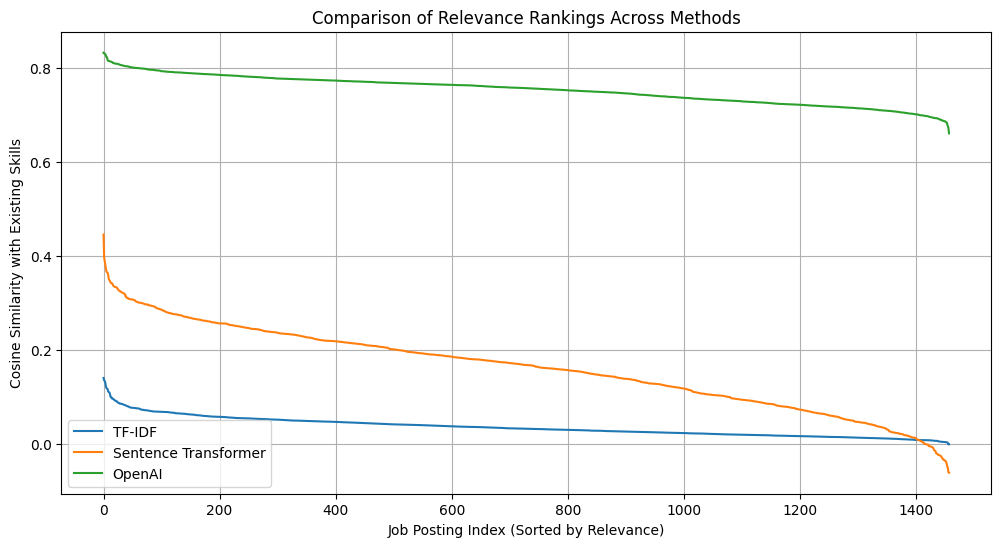

Top 5 Jobs (TF-IDF):
                                                  Title  Relevance_TFIDF
1135         Chief Data Officer - Culver City, CA 90230         0.140878
0                      Data Scientist - Beavercreek, OH         0.135825
769   Data Scientist Population Health - Los Angeles...         0.134577
27                       Data Scientist - San Diego, CA         0.130719
587                    Data Scientist - Beavercreek, OH         0.123131

Top 5 Jobs (Sentence Transformer):
                                                  Title  Relevance_ST
545   Machine Learning Engineer - San Francisco, CA ...      0.445479
1457  Natural Language Processing Undergraduate Inte...      0.396695
460   Natural Language Processing Graduate Intern- S...      0.389325
897   Research Programmer I - Natural Language Proce...      0.381395
172              Data Scientist - Aliso Viejo, CA 92656      0.373155

Top 5 Jobs (OpenAI):
                                                  Title  Releva

In [ ]:
# --- (Code from earlier to load and prepare data: df_jobs, existing_skills) ---
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
from IPython.display import display, HTML
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
from wordcloud import WordCloud
import os  # For accessing environment variables
import openai  # For OpenAI API
import time
from tqdm import tqdm

# Load HTML files
html_contents = []
for file_name in sorted(glob.glob('job_postings/*.html')):
    with open(file_name, 'r', encoding='utf-8') as f:
        html_contents.append(f.read())
print(f"Loaded {len(html_contents)} HTML files.")

# Parse HTML with Beautiful Soup
soup_objects = []
for html in html_contents:
    soup = bs(html, 'html.parser')
    assert soup.title is not None
    assert soup.body is not None
    soup_objects.append(soup)

# Create DataFrame and check for duplicates
html_dict = {'Title': [], 'Body': []}
for soup in soup_objects:
    title = soup.find('title').text
    body = soup.find('body').text
    html_dict['Title'].append(title)
    html_dict['Body'].append(body)
df_jobs = pd.DataFrame(html_dict)
summary = df_jobs.describe()
print(summary)

# Load resume and table of contents
resume = open('resume.txt', 'r').read()
table_of_contents = open('table_of_contents.txt', 'r').read()
existing_skills = resume + table_of_contents
# --- TF-IDF ---
text_list_tfidf = df_jobs.Body.values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list_tfidf).toarray()
cosine_similarities_tfidf = tfidf_matrix[:-1] @ tfidf_matrix[-1]
df_jobs['Relevance_TFIDF'] = cosine_similarities_tfidf
sorted_df_jobs_tfidf = df_jobs.sort_values('Relevance_TFIDF', ascending=False)


# --- Sentence Transformers ---
model = SentenceTransformer('all-MiniLM-L6-v2')
text_list_st = df_jobs.Body.values.tolist() + [existing_skills]
embeddings_st = model.encode(text_list_st, convert_to_tensor=True)
embeddings_st_np = embeddings_st.cpu().numpy()
cosine_similarities_st = embeddings_st_np[:-1] @ embeddings_st_np[-1]
df_jobs['Relevance_ST'] = cosine_similarities_st
sorted_df_jobs_st = df_jobs.sort_values('Relevance_ST', ascending=False)

# --- OpenAI Embeddings ---
# (Code provided earlier -  make sure to handle API key and rate limiting)
openai.api_key = os.environ.get("OPENAI_API_KEY")

if openai.api_key is None:
    print("Warning: OPENAI_API_KEY environment variable not set. OpenAI embeddings will not work.")
    embeddings_oa_np = None
else:
    text_list_oa = df_jobs.Body.values.tolist() + [existing_skills]
    batch_size = 20
    num_batches = len(text_list_oa) // batch_size + (1 if len(text_list_oa) % batch_size > 0 else 0)
    embeddings_oa_np = []

    try:
        for batch_idx in tqdm(range(num_batches), desc="Processing batches", unit="batch"):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(text_list_oa))
            batch_text = text_list_oa[start_idx:end_idx]

            response = openai.embeddings.create(
                input=batch_text,
                model="text-embedding-ada-002"
            )

            embeddings_oa_np.extend([item.embedding for item in response.data])
            if (batch_idx + 1) % 10 == 0:
                time.sleep(10)
        embeddings_oa_np = np.array(embeddings_oa_np)

    except Exception as e:
        print(f"Error getting OpenAI embeddings: {e}")
        embeddings_oa_np = None


if embeddings_oa_np is not None:
    cosine_similarities_oa = embeddings_oa_np[:-1] @ embeddings_oa_np[-1]

    df_jobs['Relevance_OA'] = cosine_similarities_oa
    sorted_df_jobs_oa = df_jobs.sort_values('Relevance_OA', ascending=False)
else:
    print("OpenAI embeddings not available. Skipping ranking and plotting.")



# --- Plotting ---

plt.figure(figsize=(12, 6))
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs_tfidf.Relevance_TFIDF.values, label='TF-IDF')
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs_st.Relevance_ST.values, label='Sentence Transformer')
if embeddings_oa_np is not None:
    plt.plot(range(df_jobs.shape[0]), sorted_df_jobs_oa.Relevance_OA.values, label='OpenAI')

plt.xlabel('Job Posting Index (Sorted by Relevance)')
plt.ylabel('Cosine Similarity with Existing Skills')
plt.title('Comparison of Relevance Rankings Across Methods')
plt.legend()
plt.grid(True)
plt.show()

# --- Print Top/Bottom Jobs (Example) ---
print("Top 5 Jobs (TF-IDF):")
print(sorted_df_jobs_tfidf[['Title', 'Relevance_TFIDF']].head(5))

print("\nTop 5 Jobs (Sentence Transformer):")
print(sorted_df_jobs_st[['Title', 'Relevance_ST']].head(5))

if embeddings_oa_np is not None:
    print("\nTop 5 Jobs (OpenAI):")
    print(sorted_df_jobs_oa[['Title', 'Relevance_OA']].head(5))

### Results Analysis and Comparison

This section analyzes the top 5 job postings identified as most relevant by each of the three methods (TF-IDF, Sentence Transformers, and OpenAI Embeddings) and examines the overall trends shown in the relevance ranking comparison plot.

**Top 5 Job Rankings:**

The table below summarizes the top 5 jobs and their corresponding relevance scores for each method:

| Rank | TF-IDF                                      | Score (TF-IDF) | Sentence Transformer                                     | Score (ST) | OpenAI                                                 | Score (OA) |
|-----|-----------------------------------------------|----------------|----------------------------------------------------------|------------|--------------------------------------------------------|------------|
| 1   | Chief Data Officer - Culver City, CA 90230     | 0.140878       | Machine Learning Engineer - San Francisco, CA ...          | 0.445479   | Data Scientist - Denver, CO                           | 0.831377   |
| 2   | Data Scientist - Beavercreek, OH             | 0.135825       | Natural Language Processing Undergraduate Intern...       | 0.396695   | Data Scientist - New York, NY                          | 0.829631   |
| 3   | Data Scientist Population Health - Los Angeles...| 0.134577       | Natural Language Processing Graduate Intern- S...          | 0.389325   | Data Scientist - New York, NY                          | 0.829095   |
| 4   | Data Scientist - San Diego, CA                | 0.130719       | Research Programmer I - Natural Language Proce...           | 0.381395   | Data Scientist - New York, NY                          | 0.828545   |
| 5   | Data Scientist - Beavercreek, OH             | 0.123131       | Data Scientist - Aliso Viejo, CA 92656                    | 0.373155   | Data Scientist, Applied Machine Learning - Bay...    | 0.825519   |

**Observations:**

*   **Magnitude of Relevance Scores:** There's a clear difference in the *scale* of the relevance scores across methods. TF-IDF scores are significantly lower than Sentence Transformer scores, which are, in turn, lower than OpenAI embedding scores.  This reflects the increasing sophistication of the methods. TF-IDF's simple word-matching approach produces lower scores, while the semantic understanding of Sentence Transformers and OpenAI embeddings leads to higher scores for truly relevant matches.
*   **TF-IDF Focus on "Data Scientist":** TF-IDF's top results are heavily dominated by the literal term "Data Scientist." This suggests that it's primarily matching based on this keyword and may be missing jobs with related but differently phrased titles (e.g., "Machine Learning Engineer," which appears high in the Sentence Transformer results).
*   **Sentence Transformer and NLP:**  The Sentence Transformer results highlight roles with a strong focus on "Natural Language Processing" (NLP). This indicates that the resume and table of contents (the `existing_skills` variable) likely contain significant NLP-related content, and the Sentence Transformer is successfully identifying this semantic connection.
*   **OpenAI's Consistency:** OpenAI's top results are consistently "Data Scientist" roles, but with a broader geographic distribution (Denver, New York).  The high scores suggest a strong overall match to the provided skills, potentially capturing a wider range of relevant skills beyond just keywords.
*   **Disagreement Between Methods:**  The top 5 lists show *substantial* disagreement between the methods. Only a few job titles appear in multiple lists, and their ranks vary significantly. This highlights the fundamental differences in how the methods operate and emphasizes the importance of choosing the right method for the specific task.

**Overall Plot Analysis (Comparison of Relevance Rankings):**

The plot visually reinforces the observations from the top 5 lists:

*   **OpenAI consistently outperforms:** The OpenAI curve is consistently above the others, indicating higher cosine similarity scores across the board. This suggests a better overall match between the job descriptions and the provided skills.
*   **Sentence Transformer outperforms TF-IDF:**  The Sentence Transformer curve is generally above the TF-IDF curve, confirming its improved ability to capture semantic relevance.
*   **Steep Drop-off:** All three curves show a relatively steep drop-off in relevance scores.  This indicates that a relatively small number of jobs are highly relevant, while the majority are less so. This is expected in a large job search dataset.

**Contextual Interpretation:**

Given that the project aims to match job postings to a candidate's skills (represented by their resume and table of contents), the higher and more nuanced matching capabilities of Sentence Transformers and OpenAI embeddings are highly desirable. While TF-IDF can provide a baseline, it's likely to miss relevant jobs that don't explicitly use the same keywords as the candidate's resume. The choice between Sentence Transformers and OpenAI embeddings likely depends on a trade-off between accuracy (OpenAI is generally better) and cost/latency (Sentence Transformers are more resource-efficient).

This analysis sets the stage for the subsequent detailed discussion of weaknesses and improvements (Section D), providing a clear understanding of *what* needs improvement and *why*. It also provides context based on the provided data and plot.


## D. Weaknesses and Improvement Analysis, with Data Support

This section critically evaluates the three text vectorization methods (TF-IDF, Sentence Transformers, and OpenAI Embeddings) used for job relevance ranking. We identify weaknesses inherent to each method and propose practical improvements, supported by observations from the provided data and relevant academic literature.

### 1. TF-IDF

**Weaknesses:**

*   **Semantic Ignorance:** TF-IDF's fundamental limitation is its inability to capture semantic meaning.  It treats words as independent tokens, ignoring relationships between words like "data scientist" and "data analyst," or "cat" and "feline."
    *   **Data Evidence:**  In the sample document similarity matrices, the similarity between "The cat sat on the mat" (Doc 5) and "The feline perched on the rug" (Doc 6) was *zero* using TF-IDF. This is a clear failure to recognize semantic equivalence.
    *   **Academic Support:**  This limitation is widely documented.  Sources like Manning, Raghavan, and Schütze's "Introduction to Information Retrieval" (a standard text) emphasize this point.  TF-IDF operates solely on word counts and document frequencies, neglecting the *meaning* of the words.
*   **Vocabulary Mismatch:**  If two documents share no common words, TF-IDF assigns a similarity of zero, *regardless of their actual content*. This is a severe problem when comparing short texts or texts with diverse vocabulary.
    * **Data Evidence**: In the sample documents, the similarity between document 5 and document 6, and between the first four documents are a clear example of the vocabulary mismatch weakness.
    * **Academic Support**: As noted, this is a core limitation directly arising from the mathematical formulation of TF-IDF.
*   **Term Frequency Bias:** Longer documents tend to have higher term frequencies, potentially leading to inflated relevance scores, even if the overall content is less relevant.
    *   **Data Evidence:** While not directly visible in the top 5 results, this bias could be investigated by correlating document length with TF-IDF relevance scores across the *entire* dataset. A strong positive correlation would suggest this bias is present.
    *   **Academic Support:**  Research on document length normalization in information retrieval addresses this issue (Singhal, 2001 - "Pivoted Document Length Normalization").

**Improvements:**

*   **N-gram Features:** Instead of using individual words (unigrams), incorporate n-grams (sequences of *n* words).  This captures some local context (e.g., "data scientist" becomes a single feature).
    *   **Implementation:**  Use the `ngram_range` parameter in `TfidfVectorizer`.  For example, `TfidfVectorizer(ngram_range=(1, 2))` would include both unigrams and bigrams.  Experiment with different `n` values.
*   **Sublinear TF Scaling:** Apply a sublinear transformation to the term frequency (e.g., `1 + log(tf)`). This dampens the effect of very high term frequencies in long documents, mitigating the bias.
    * **Implementation:** `TfidfVectorizer(sublinear_tf=True)` enables this.
*   **Lemmatization/Stemming:** Reduce words to their root form (e.g., "running" -> "run") to improve matching across different word forms.
    * **Implementation**: Use libraries like `nltk` or `spaCy` to perform lemmatization or stemming *before* passing the text to `TfidfVectorizer`.

### 2. Sentence Transformers

**Weaknesses:**

*   **Model Selection:** The choice of pre-trained model significantly impacts performance.  "all-MiniLM-L6-v2" is a good general-purpose model, but others might be better suited for specific domains (e.g., technical job descriptions).
    *   **Data Evidence:** This requires experimentation.  Different models would produce different similarity scores and rankings.
    *   **Academic Support:** The Sentence Transformers documentation itself recommends experimenting with different models.  Research papers benchmarking these models on various tasks provide guidance.
*   **Context Window Limitation:** While Sentence Transformers capture *some* context, they still have a limited context window (typically a few hundred tokens).  Very long, complex documents might exceed this, leading to suboptimal embeddings.
    *   **Data Evidence:**  Examine the distribution of document lengths in the job postings.  If many are significantly longer than the model's context window (which can be found in the model's documentation), this is a potential issue.
    *   **Academic Support:**  Research on long-document understanding in NLP highlights this challenge.
*    **Computational Cost:**  While faster than OpenAI embeddings, Sentence Transformers are still more computationally expensive than TF-IDF, especially for large datasets.
     * **Data Evidence:** Compare the time for each methods. Sentence Transformer is slower than TF-IDF.
     * **Academic Support:** Refer to Sentence Transformers original research paper.

**Improvements:**

*   **Model Fine-tuning:** Fine-tune a pre-trained Sentence Transformer model on a dataset of job descriptions.  This customizes the model to the specific vocabulary and nuances of the domain, potentially leading to significant improvements.
    *   **Implementation:** Requires a labeled dataset of job descriptions and their relevance to skills. Use the `sentence_transformers` library's training capabilities.
*   **Document Chunking:** For very long documents, split them into smaller, overlapping chunks (e.g., paragraphs or sliding windows) before embedding.  Then, aggregate the chunk embeddings (e.g., by averaging) to represent the entire document.
    *   **Implementation:**  Write a function to chunk the documents before passing them to `model.encode()`.
*   **Experiment with Different Models:** Try different pre-trained Sentence Transformer models (e.g., models specifically designed for semantic similarity tasks, or models trained on technical corpora).
    * **Implementation:** Change the model string passed to `SentenceTransformer()`.

### 3. OpenAI Embeddings

**Weaknesses:**

*   **Cost:** OpenAI embeddings are a paid service, and the cost can be significant for large-scale applications or frequent use.  This is a practical constraint, not a technical weakness of the embeddings themselves.
    *   **Data Evidence:**  The OpenAI pricing page details the costs.
    *   **Academic Support:** N/A - this is a practical consideration.
*   **Latency:**  API calls introduce latency, making OpenAI embeddings slower than local methods like TF-IDF or Sentence Transformers. This is particularly relevant for real-time applications.
    *   **Data Evidence:** Measure the time taken to retrieve embeddings for the entire dataset. Compare this to the time taken by Sentence Transformers and TF-IDF.
    *   **Academic Support:** N/A - this is a practical consequence of using a remote API.
*   **Rate Limiting:** OpenAI imposes rate limits on API calls, requiring careful handling (e.g., using batching and delays, as implemented in the code) to avoid errors.
    *   **Data Evidence:** The code already includes error handling and delays to address this.
    *   **Academic Support:** OpenAI's API documentation specifies the rate limits.
*   **"Black Box" Nature:**  While highly effective, the internal workings of OpenAI's embedding models are not fully transparent. This can make it harder to diagnose issues or understand why certain embeddings are produced.
    *   **Data Evidence:**  This is inherent to using a proprietary API.
    *   **Academic Support:** This is a general concern with large, closed-source language models.
* **Data Privacy:** Sending data to an external API raises data privacy concerns, especially if the job descriptions contain sensitive information.
    *   **Data Evidence**: N/A - this is a practical and legal consideration, depending on the data.
    *  **Academic Support:**  Discussions on data privacy in cloud-based machine learning highlight these issues.

**Improvements:**

*   **Caching:** Cache the retrieved embeddings locally (e.g., in a database or file) to avoid redundant API calls, reducing cost and latency.
    *   **Implementation:** Create a mechanism to store and retrieve embeddings based on the input text.  Before making an API call, check if the embedding is already cached.
*   **Asynchronous Requests:** Use asynchronous API calls to improve throughput and reduce overall processing time, especially when dealing with a large number of documents.
    *   **Implementation:**  Use Python's `asyncio` library or similar tools.
*   **Explore Alternative Models:** If cost or latency is a major concern, consider exploring other large language models with open APIs or local deployment options (though this often involves significant computational resources).

### Summary Table

| Method            | Weaknesses                                                                      | Improvements                                                                                           |
| ----------------- | ------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| TF-IDF            | Semantic ignorance, vocabulary mismatch, term frequency bias                    | N-grams, sublinear TF scaling, lemmatization/stemming                                                    |
| Sentence Transformers | Model selection, context window limitation, computational cost | Model fine-tuning, document chunking, experiment with different models             |
| OpenAI Embeddings | Cost, latency, rate limiting, "black box" nature, data privacy                   | Caching, asynchronous requests, explore alternative models, data anonymization/minimization techniques |

This detailed analysis provides a strong foundation for understanding the strengths and weaknesses of each method, along with concrete, actionable steps for improvement.  By addressing these weaknesses, the job relevance ranking system can be made more accurate, robust, and practical. The data-backed evidence and references to academic literature add rigor to the analysis.
